In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

c:\Users\bosea\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Evaluation Metrics

Even though ratings can be anything from 1 to 5, we should think of ratings as positive (1-2), neutral (3), or positive (4-5). This makes intuitive sense as most customers rating a product 1-2 would most likely not recommend it or purchase it again, and vice versa for ratings of 4-5. Ratings of 3 are somewhat unique in that the customer may or may not reccommend the product based on their individual experience. 

Therefore we primarily need to think about evaluating our model from the perspective of FALSE POSITIVES and FALSE NEGATIVES. 
- FALSE POSITIVES occur when the model mis-classifies a true negative or neutral review as a positive one. 
- FALSE NEGATIVES occur when the model mis-classifies a true positive or neutral review as a negative one. 

Most companies would be more concerned about the FALSE POSITIVE cases, since they do not want bad products ending up getting classified as good because it would negatively affect their brand. Conversely, if a good product is incorrectly classified, thus making the classification a FALSE NEGATIVE, the company's brand will not be as negatively impacted since the human reviews should correct the error. 

Therefore, we will choose evaluation metrics that <u>minimize</u> the occurrence of FALSE POSITIVES

#### Classification Report Definitions

We will be using the standard SciKit-Learn classification report metrics: precision, recall, F-1 score. As such, let's review their definitions:

- `Precision` measures the number of reviews correctly classified as positive divided by the total number of reviews classified as positive. 
    * precision = TP/(TP + FP)
    * What proportion of predicted positive reviews were correctly classified as positive?
    * When we minimize false positives, precision increases


- `Recall` (or Sensitivity) measures the number of reviews correctly classified as positive divided by the total number of actually positive reviews.
    * recall = TP/(TP + FN)
    * What proportion of actually positive reviews were correctly classified as positive?
    * When we minimize false negatives, recall increases


- `F1-Score` is a measure which combines Precision and Recall. It is essentially the harmonic mean of Precision and Recall, and it puts equal emphasis on both. 
    * F-1 Score = 2 * (Precision * Recall)/(Precision + Recall)
    * Gives equal importance to both precision and recall
    * Should be used when we want to have a balance between Precision and Recall, AND there is an uneven class distribution
    

Given the information above, we will seek to <u>maximize</u> PRECISION of the "positive" class of reviews.

### Data Loading

In [5]:
# load the pre-saved csv of featurized columns, bringing in only the columns needed
df = pd.read_csv('../data/final/beauty_reviews_featurized.csv', usecols= ['rating','full_review','target','lemma_sent'])

In [6]:
# check data types
df.dtypes

rating          int64
full_review    object
target         object
lemma_sent     object
dtype: object

In [7]:
# convert the "lemma_sent" column to string for later pre-processing
df["lemma_sent"] = df["lemma_sent"].astype(str)

In [11]:
df.head()

,rating,full_review,target,lemma_sent
0,1,One Star great,negative,star great
1,4,... to reading about the Negro Baseball and th...,positive,read negro baseball great addition library lib...
2,4,"Worth the Read This book was very informative,...",positive,worth read book informative cover aspects game
3,5,Good Read I am already a baseball fan and knew...,positive,good read baseball fan know bite negro league ...
4,5,"More than facts, a good story read! This was a...",positive,facts good story read good story black league ...


### Word Modeling and Classification Algorithms

We will use three different types of word-modeling techniques
- Bag of words
- N-grams
- TF-IDF

We will use five different classification algorithms
- Multinomial Naive Bayes
- Logistic Regression
- Linear Support Vector Classifier
- Random Forest
- XGBoost

#### Data Partitioning

In [17]:
# create train/test splits
X = df[["rating", "full_review", "lemma_sent"]] # keeping the 'rating' and 'full_review' columns for later error analysis notebook
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # check shape of test and train datasets

(259662, 3) (111284, 3) (259662,) (111284,)


In [18]:
# save train and test datasets to csv for model tuning and optimization purposes
pd.concat([X_train, y_train], axis=1).to_csv('../data/final/train.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('../data/final/test.csv', index=False)

In [19]:
# drop the 'full_review' column from X_train and X_test
X_train.drop(["rating", 'full_review'], inplace=True, axis= 1)
X_test.drop(["rating", 'full_review'], inplace=True, axis= 1)

In [7]:
# define the preprocessor pipelines
MAX_FEAT = 5000 # maximum features from the word vector representation
TARGETS = ["negative", "neutral", "positive"]

# define the types of word-modeling
bow_vec = CountVectorizer(max_features=MAX_FEAT)
n_grams_vec = CountVectorizer(max_features=MAX_FEAT, ngram_range=(1, 3))
tfidf_vec = TfidfVectorizer(max_features=MAX_FEAT)

# define classification models
nb_base = MultinomialNB()
log_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
svc_base = LinearSVC(class_weight='balanced', max_iter=MAX_FEAT)
rf_base = RandomForestClassifier(random_state=42)
xgb_base = XGBClassifier(random_state=42, seed=42)

# define dict to store above models
models = {
    'Multinomial Naive Bayes': nb_base,
    'Logistic Regression': log_base,
    'Linear Support Vector Classifier': svc_base,
    'Random Forest': rf_base, 
    'XGBoost Classifier': xgb_base}

# models = {
#     'Multinomial Naive Bayes': nb_base,
#     'Logistic Regression': log_base
#     }

#### Helper Function

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

#### Bag of Words Models

Training Set Classification Report: Multinomial Naive Bayes

-------------------------------------
              precision    recall  f1-score   support

    negative       0.71      0.59      0.65     41707
     neutral       0.32      0.30      0.31     20714
    positive       0.88      0.92      0.90    197241

    accuracy                           0.82    259662
   macro avg       0.64      0.60      0.62    259662
weighted avg       0.81      0.82      0.81    259662

Test Set Classification Report: Multinomial Naive Bayes

-------------------------------------
              precision    recall  f1-score   support

    negative       0.70      0.60      0.65     17803
     neutral       0.31      0.27      0.29      8826
    positive       0.88      0.92      0.90     84655

    accuracy                           0.82    111284
   macro avg       0.63      0.60      0.61    111284
weighted avg       0.81      0.82      0.81    111284

Confusion Matrix : Multinomial Naive Bayes



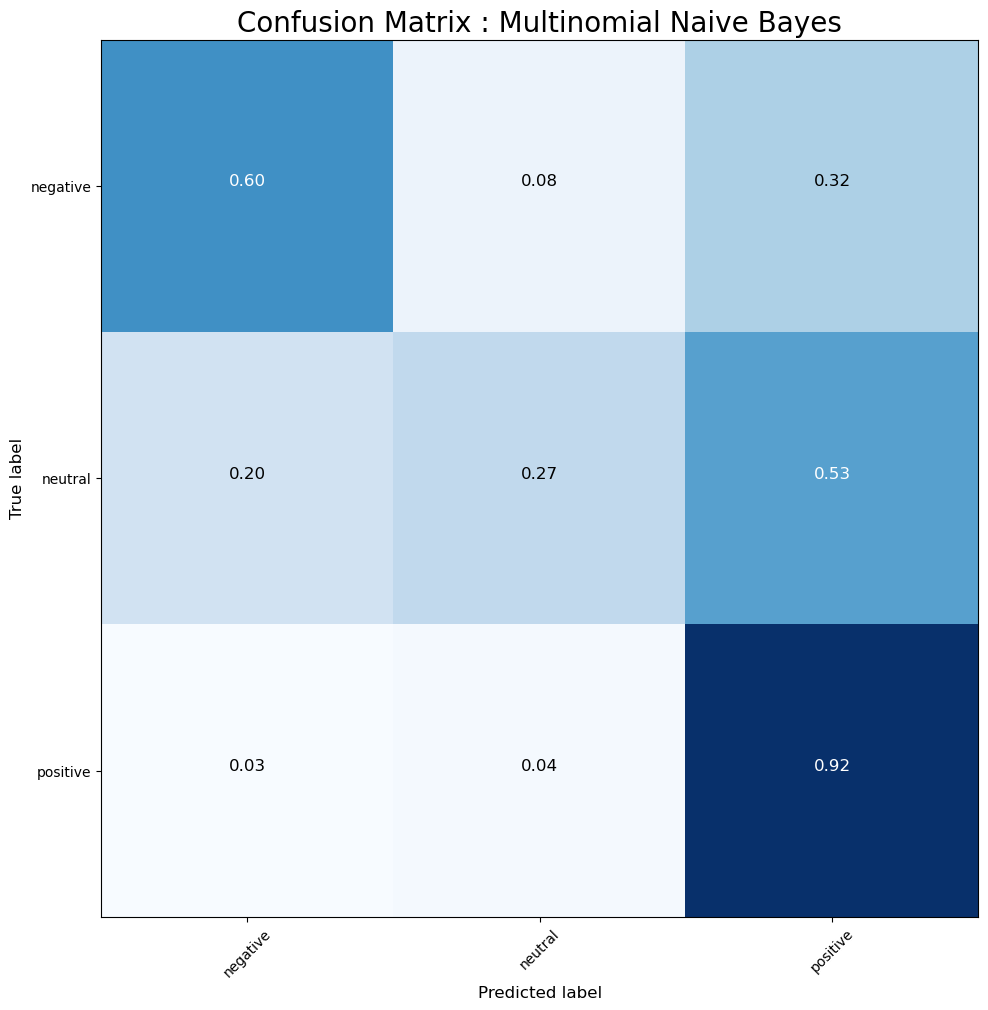

Training Set Classification Report: Logistic Regression

-------------------------------------
              precision    recall  f1-score   support

    negative       0.60      0.73      0.65     41707
     neutral       0.25      0.52      0.34     20714
    positive       0.95      0.80      0.87    197241

    accuracy                           0.77    259662
   macro avg       0.60      0.68      0.62    259662
weighted avg       0.84      0.77      0.79    259662

Test Set Classification Report: Logistic Regression

-------------------------------------
              precision    recall  f1-score   support

    negative       0.59      0.71      0.65     17803
     neutral       0.24      0.48      0.32      8826
    positive       0.95      0.80      0.87     84655

    accuracy                           0.76    111284
   macro avg       0.59      0.67      0.61    111284
weighted avg       0.83      0.76      0.79    111284

Confusion Matrix : Logistic Regression

------------

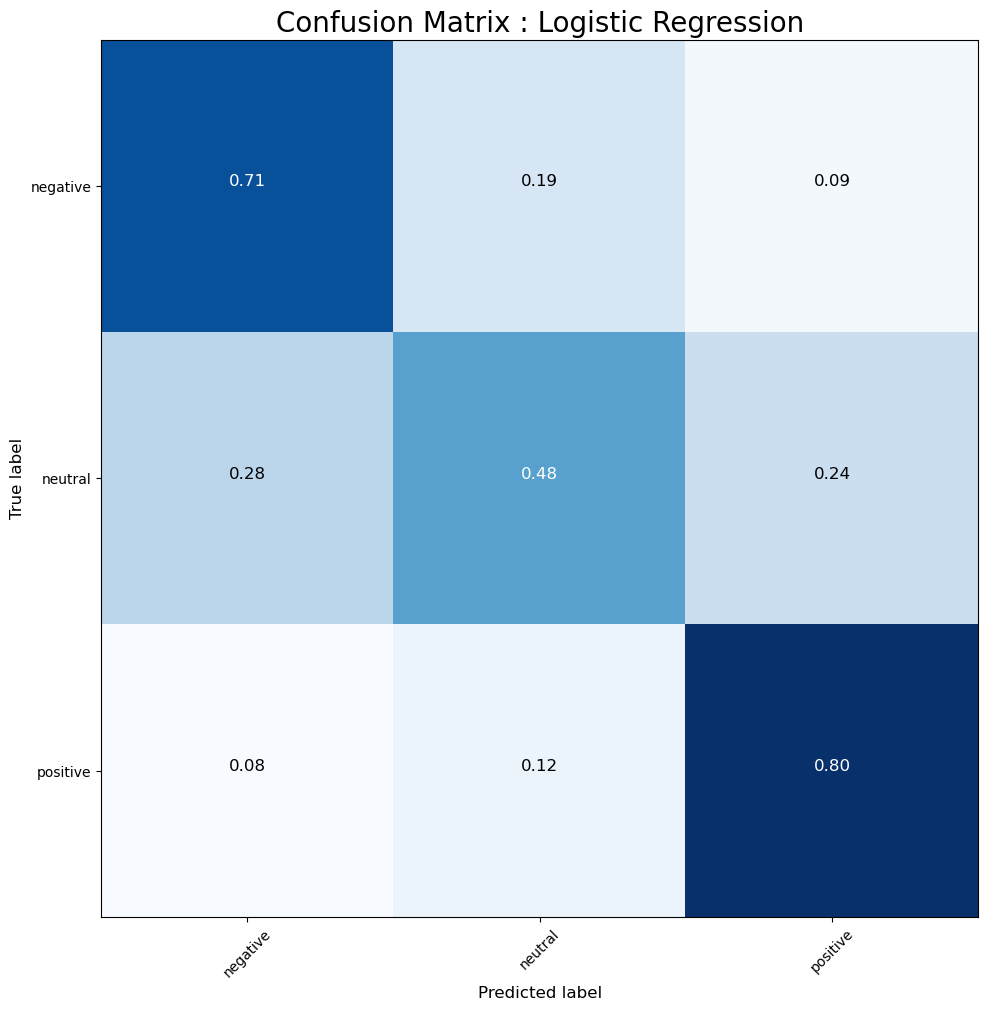

c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Set Classification Report: Linear Support Vector Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.67      0.69      0.68     41707
     neutral       0.36      0.32      0.34     20714
    positive       0.91      0.92      0.91    197241

    accuracy                           0.83    259662
   macro avg       0.65      0.64      0.64    259662
weighted avg       0.83      0.83      0.83    259662



c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Set Classification Report: Linear Support Vector Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.66      0.68      0.67     17803
     neutral       0.31      0.30      0.31      8826
    positive       0.91      0.91      0.91     84655

    accuracy                           0.82    111284
   macro avg       0.63      0.63      0.63    111284
weighted avg       0.82      0.82      0.82    111284

Confusion Matrix : Linear Support Vector Classifier

-------------------------------------


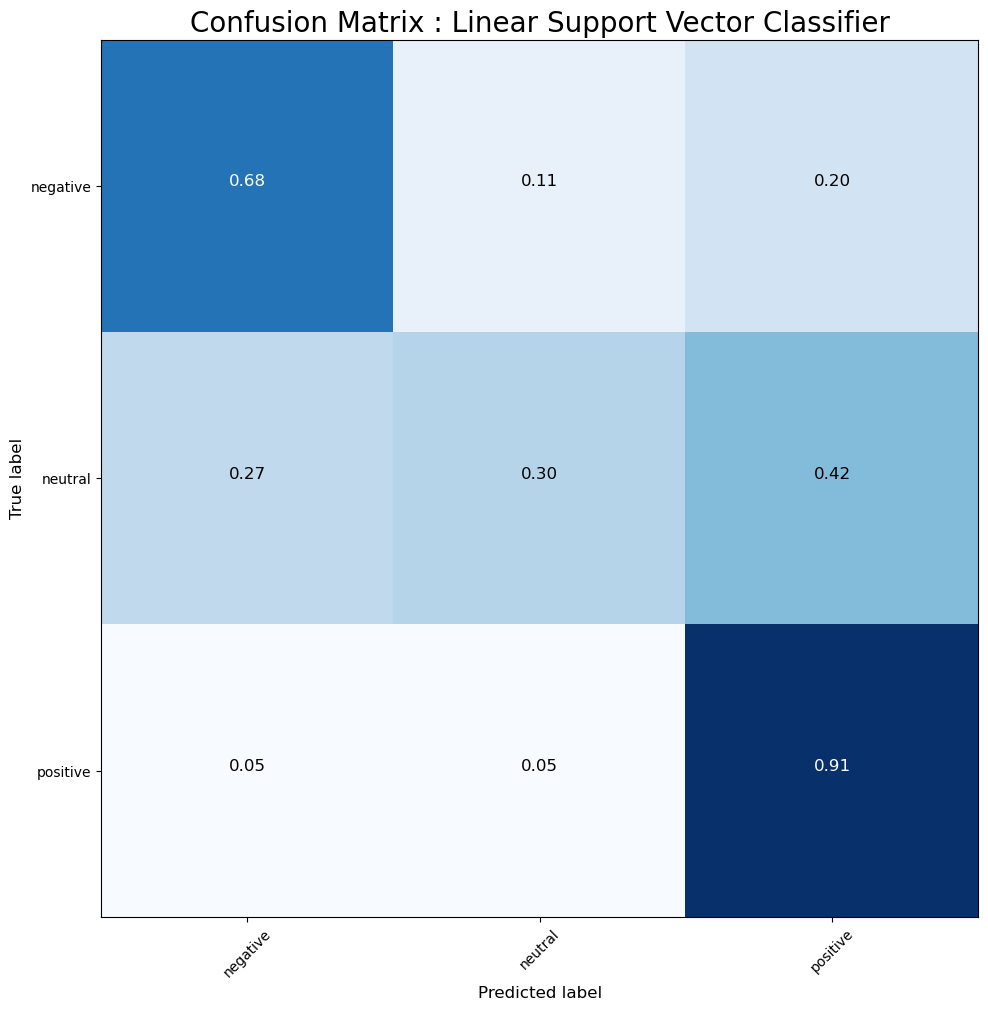

Training Set Classification Report: Random Forest

-------------------------------------
              precision    recall  f1-score   support

    negative       0.74      0.60      0.67     41707
     neutral       0.58      0.15      0.23     20714
    positive       0.87      0.97      0.92    197241

    accuracy                           0.85    259662
   macro avg       0.73      0.57      0.60    259662
weighted avg       0.83      0.85      0.82    259662

Test Set Classification Report: Random Forest

-------------------------------------
              precision    recall  f1-score   support

    negative       0.73      0.58      0.65     17803
     neutral       0.51      0.11      0.18      8826
    positive       0.86      0.97      0.91     84655

    accuracy                           0.84    111284
   macro avg       0.70      0.55      0.58    111284
weighted avg       0.81      0.84      0.81    111284

Confusion Matrix : Random Forest

------------------------------

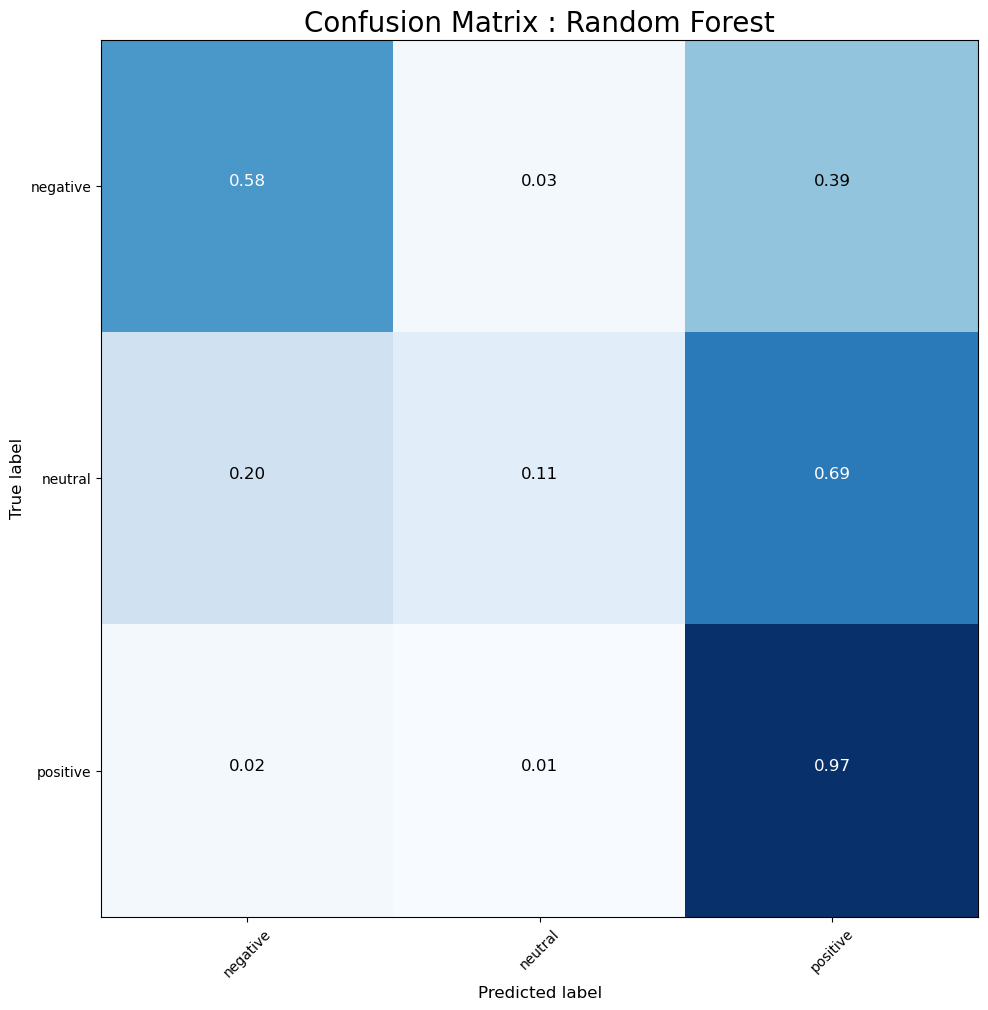

c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Set Classification Report: XGBoost Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.49      0.60     41707
     neutral       0.54      0.14      0.23     20714
    positive       0.85      0.98      0.91    197241

    accuracy                           0.83    259662
   macro avg       0.72      0.54      0.58    259662
weighted avg       0.81      0.83      0.80    259662



c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Set Classification Report: XGBoost Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.50      0.61     17803
     neutral       0.51      0.13      0.20      8826
    positive       0.85      0.98      0.91     84655

    accuracy                           0.83    111284
   macro avg       0.72      0.54      0.57    111284
weighted avg       0.81      0.83      0.81    111284

Confusion Matrix : XGBoost Classifier

-------------------------------------


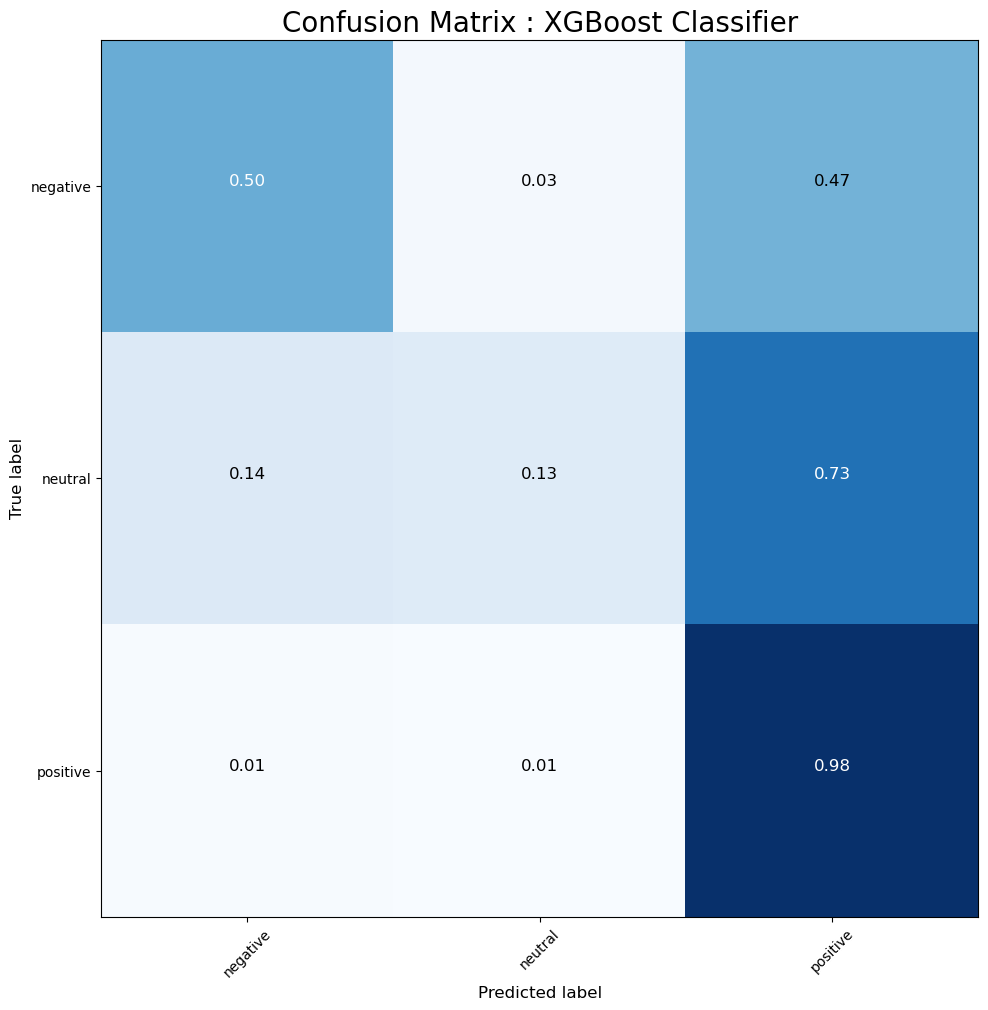

In [11]:
# set up loop to 

for model in models.items():
    
    # create the pipeline
    pipe = Pipeline([
        ('vec', bow_vec),
        ('clf', model[1])
    ])

    # print train classification report
    y_train_pred = cross_val_predict(pipe, X_train, y_train)
    print(f'Training Set Classification Report: {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_train, y_train_pred, target_names=TARGETS))

     # print test classification report
    y_test_pred = cross_val_predict(pipe, X_test, y_test)
    print(f'Test Set Classification Report: {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_test, y_test_pred, target_names=TARGETS))

    # print confusion matrices
    print(f'Confusion Matrix : {model[0]}\n')
    print('-------------------------------------')
    plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=TARGETS, normalize=True, title=f'Confusion Matrix : {model[0]}')
    plt.grid(False)
    plt.savefig(f'../assets/bow_{model[0].replace(" ", "_").lower()}.png')
    plt.show()

#### N-gram models

Training Set Classification Report: Multinomial Naive Bayes

-------------------------------------
              precision    recall  f1-score   support

    negative       0.68      0.64      0.66     41707
     neutral       0.29      0.36      0.32     20714
    positive       0.90      0.89      0.90    197241

    accuracy                           0.81    259662
   macro avg       0.62      0.63      0.63    259662
weighted avg       0.82      0.81      0.81    259662

Test Set Classification Report: Multinomial Naive Bayes

-------------------------------------
              precision    recall  f1-score   support

    negative       0.67      0.65      0.66     17803
     neutral       0.28      0.33      0.30      8826
    positive       0.90      0.89      0.90     84655

    accuracy                           0.81    111284
   macro avg       0.62      0.62      0.62    111284
weighted avg       0.82      0.81      0.81    111284

Confusion Matrix : Multinomial Naive Bayes



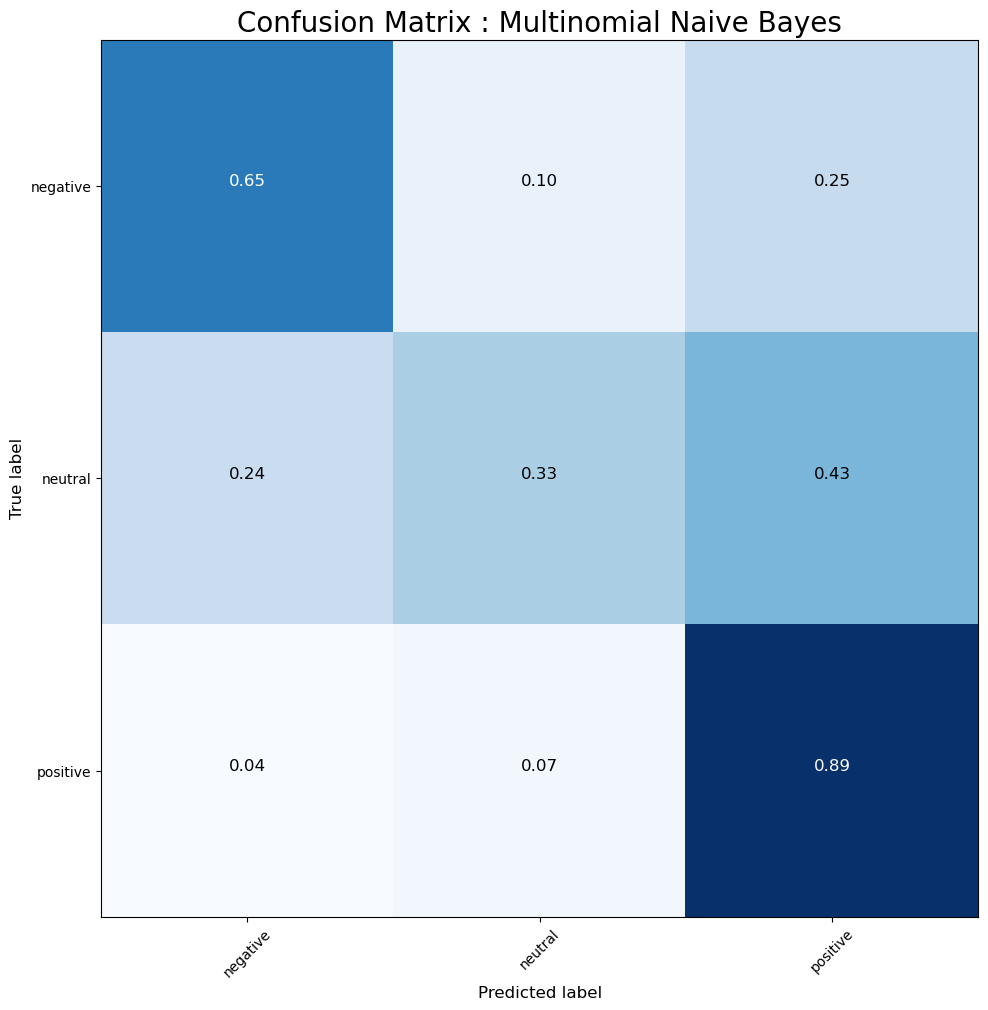

Training Set Classification Report: Logistic Regression

-------------------------------------
              precision    recall  f1-score   support

    negative       0.59      0.73      0.65     41707
     neutral       0.24      0.52      0.33     20714
    positive       0.96      0.79      0.87    197241

    accuracy                           0.76    259662
   macro avg       0.60      0.68      0.62    259662
weighted avg       0.84      0.76      0.79    259662

Test Set Classification Report: Logistic Regression

-------------------------------------
              precision    recall  f1-score   support

    negative       0.58      0.72      0.64     17803
     neutral       0.23      0.48      0.31      8826
    positive       0.95      0.80      0.87     84655

    accuracy                           0.76    111284
   macro avg       0.59      0.66      0.61    111284
weighted avg       0.83      0.76      0.79    111284

Confusion Matrix : Logistic Regression

------------

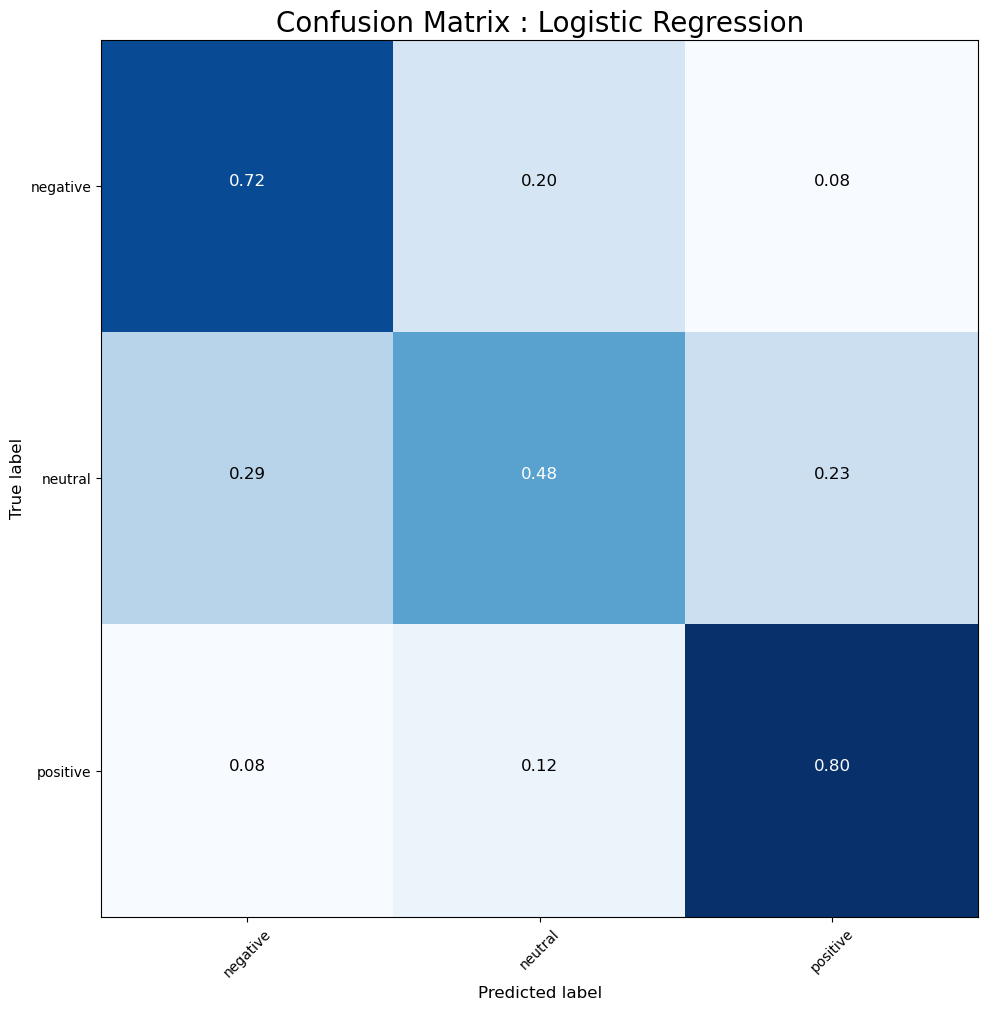

c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Set Classification Report: Linear Support Vector Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.64      0.74      0.69     41707
     neutral       0.35      0.34      0.35     20714
    positive       0.93      0.90      0.91    197241

    accuracy                           0.83    259662
   macro avg       0.64      0.66      0.65    259662
weighted avg       0.84      0.83      0.83    259662



c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Set Classification Report: Linear Support Vector Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.63      0.72      0.67     17803
     neutral       0.31      0.33      0.32      8826
    positive       0.92      0.89      0.91     84655

    accuracy                           0.82    111284
   macro avg       0.62      0.65      0.63    111284
weighted avg       0.83      0.82      0.82    111284

Confusion Matrix : Linear Support Vector Classifier

-------------------------------------


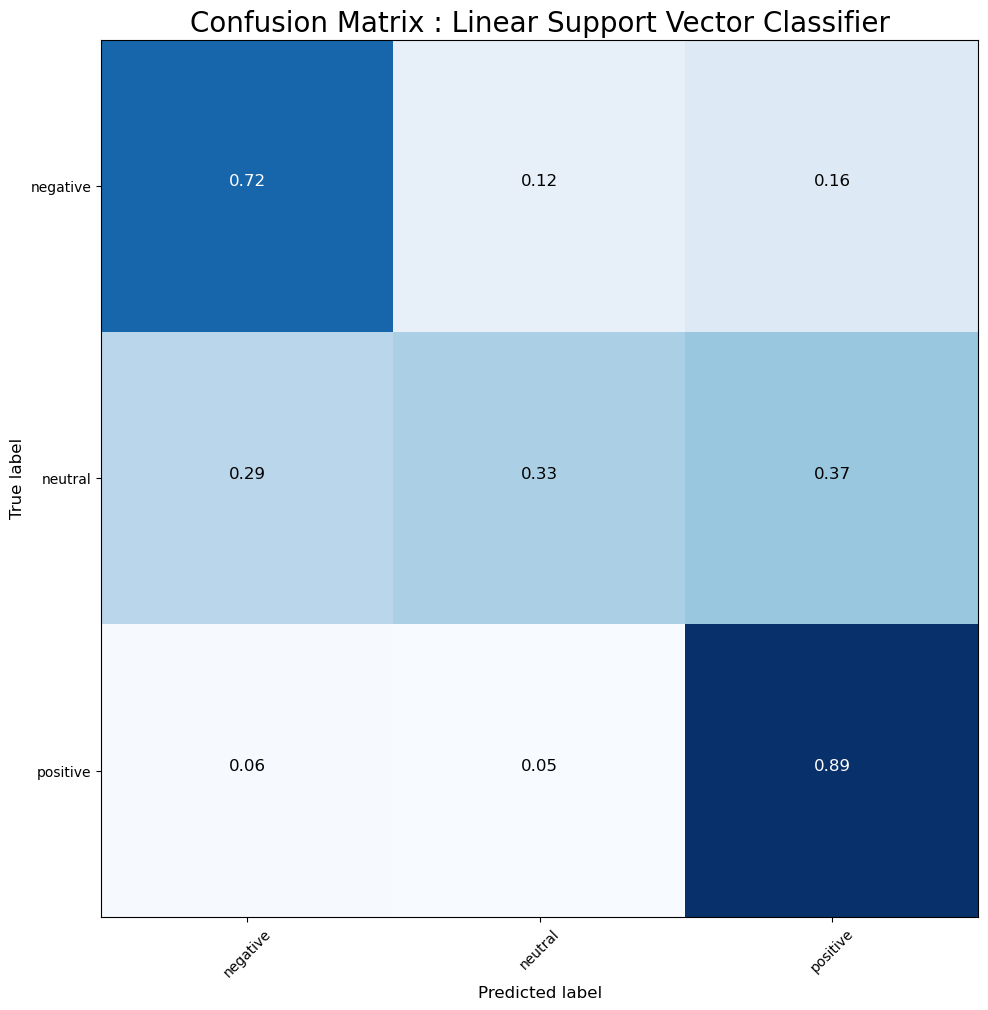

Training Set Classification Report: Random Forest

-------------------------------------
              precision    recall  f1-score   support

    negative       0.73      0.62      0.67     41707
     neutral       0.58      0.15      0.24     20714
    positive       0.87      0.97      0.92    197241

    accuracy                           0.85    259662
   macro avg       0.73      0.58      0.61    259662
weighted avg       0.83      0.85      0.82    259662

Test Set Classification Report: Random Forest

-------------------------------------
              precision    recall  f1-score   support

    negative       0.73      0.60      0.66     17803
     neutral       0.49      0.12      0.19      8826
    positive       0.87      0.97      0.91     84655

    accuracy                           0.84    111284
   macro avg       0.70      0.56      0.59    111284
weighted avg       0.82      0.84      0.82    111284

Confusion Matrix : Random Forest

------------------------------

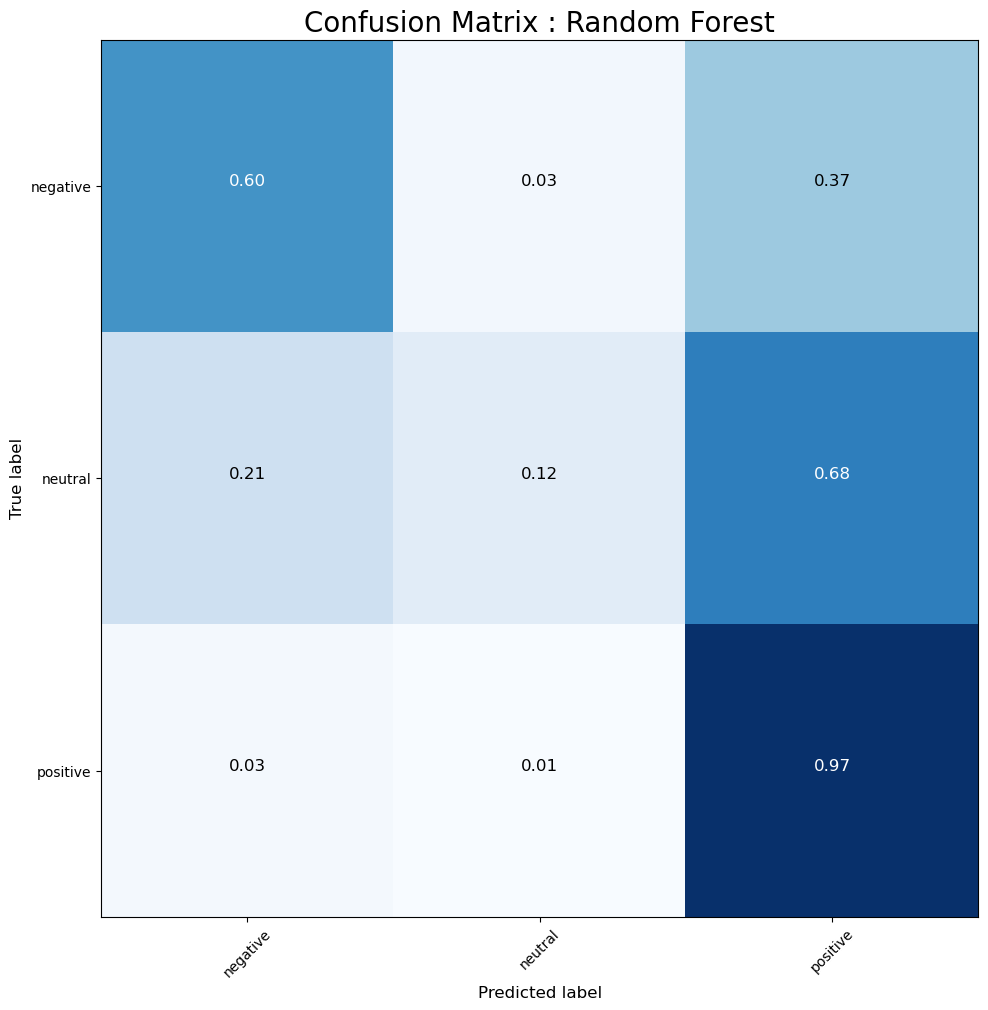

c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Set Classification Report: XGBoost Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.49      0.61     41707
     neutral       0.53      0.15      0.23     20714
    positive       0.85      0.98      0.91    197241

    accuracy                           0.83    259662
   macro avg       0.72      0.54      0.58    259662
weighted avg       0.81      0.83      0.81    259662



c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Set Classification Report: XGBoost Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.80      0.50      0.61     17803
     neutral       0.51      0.13      0.20      8826
    positive       0.85      0.98      0.91     84655

    accuracy                           0.84    111284
   macro avg       0.72      0.54      0.58    111284
weighted avg       0.81      0.84      0.81    111284

Confusion Matrix : XGBoost Classifier

-------------------------------------


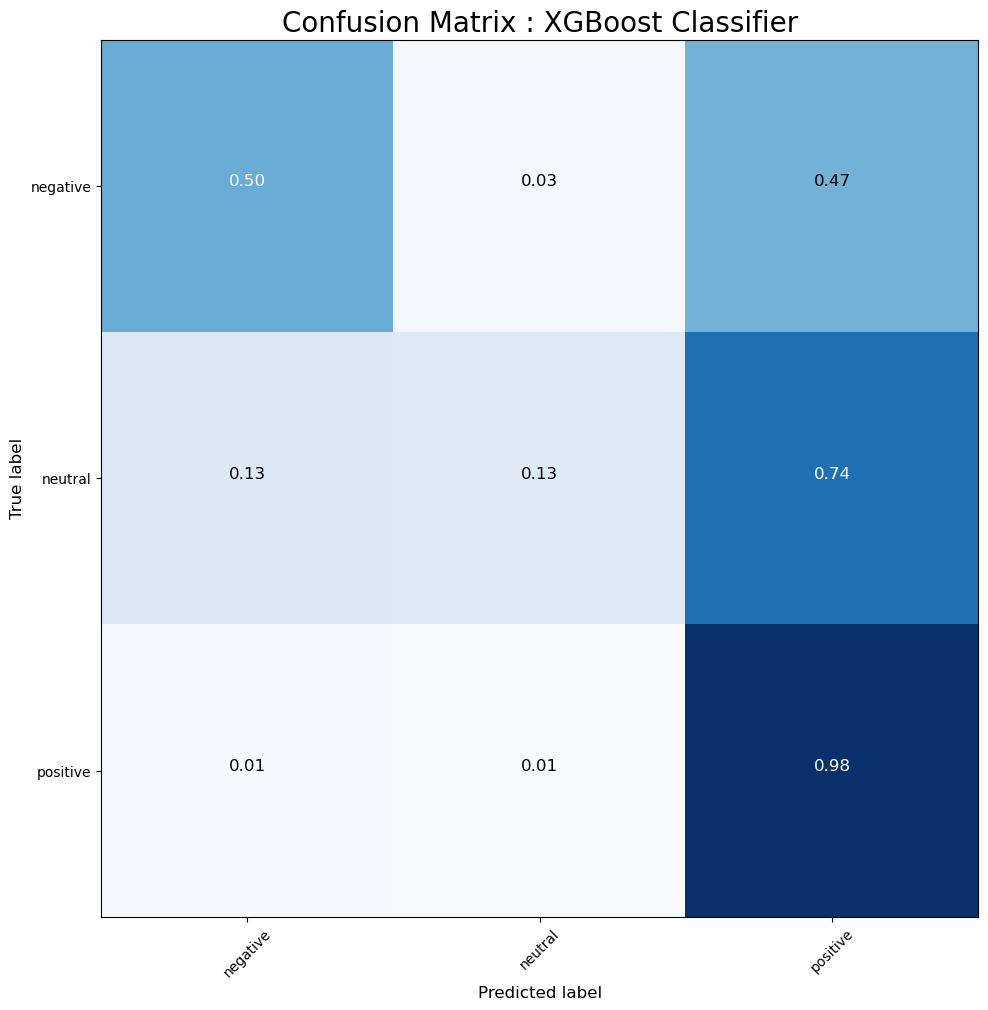

In [12]:
# set up loop to 

for model in models.items():
    
    # create the pipeline
    pipe = Pipeline([
        ('vec', n_grams_vec),
        ('clf', model[1])
    ])

    # print train classification report
    y_train_pred = cross_val_predict(pipe, X_train, y_train)
    print(f'Training Set Classification Report: {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_train, y_train_pred, target_names=TARGETS))

     # print test classification report
    y_test_pred = cross_val_predict(pipe, X_test, y_test)
    print(f'Test Set Classification Report: {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_test, y_test_pred, target_names=TARGETS))

    # print confusion matrices
    print(f'Confusion Matrix : {model[0]}\n')
    print('-------------------------------------')
    plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=TARGETS, normalize=True, title=f'Confusion Matrix : {model[0]}')
    plt.grid(False)
    plt.savefig(f'../assets/ngram_{model[0].replace(" ", "_").lower()}.png')
    plt.show()

#### TF-IDF Models

Training Set Classification Report: Multinomial Naive Bayes

-------------------------------------
              precision    recall  f1-score   support

    negative       0.84      0.38      0.52     41707
     neutral       0.61      0.02      0.04     20714
    positive       0.82      0.99      0.90    197241

    accuracy                           0.82    259662
   macro avg       0.76      0.46      0.48    259662
weighted avg       0.80      0.82      0.77    259662

Test Set Classification Report: Multinomial Naive Bayes

-------------------------------------
              precision    recall  f1-score   support

    negative       0.86      0.36      0.51     17803
     neutral       0.54      0.01      0.02      8826
    positive       0.81      0.99      0.89     84655

    accuracy                           0.81    111284
   macro avg       0.74      0.46      0.47    111284
weighted avg       0.80      0.81      0.76    111284

Confusion Matrix : Multinomial Naive Bayes



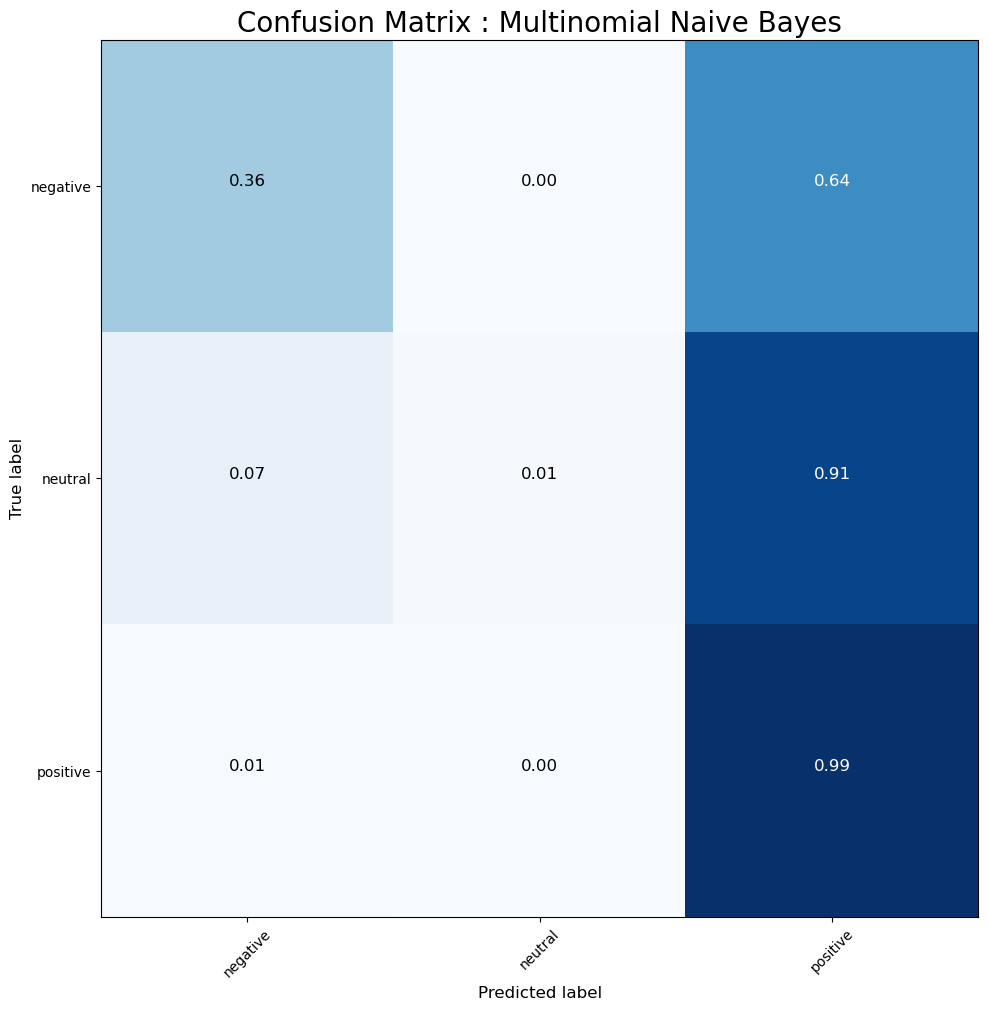

Training Set Classification Report: Logistic Regression

-------------------------------------
              precision    recall  f1-score   support

    negative       0.61      0.72      0.66     41707
     neutral       0.24      0.56      0.34     20714
    positive       0.96      0.79      0.87    197241

    accuracy                           0.76    259662
   macro avg       0.60      0.69      0.62    259662
weighted avg       0.85      0.76      0.79    259662

Test Set Classification Report: Logistic Regression

-------------------------------------
              precision    recall  f1-score   support

    negative       0.60      0.72      0.66     17803
     neutral       0.23      0.53      0.33      8826
    positive       0.96      0.79      0.86     84655

    accuracy                           0.76    111284
   macro avg       0.60      0.68      0.62    111284
weighted avg       0.84      0.76      0.79    111284

Confusion Matrix : Logistic Regression

------------

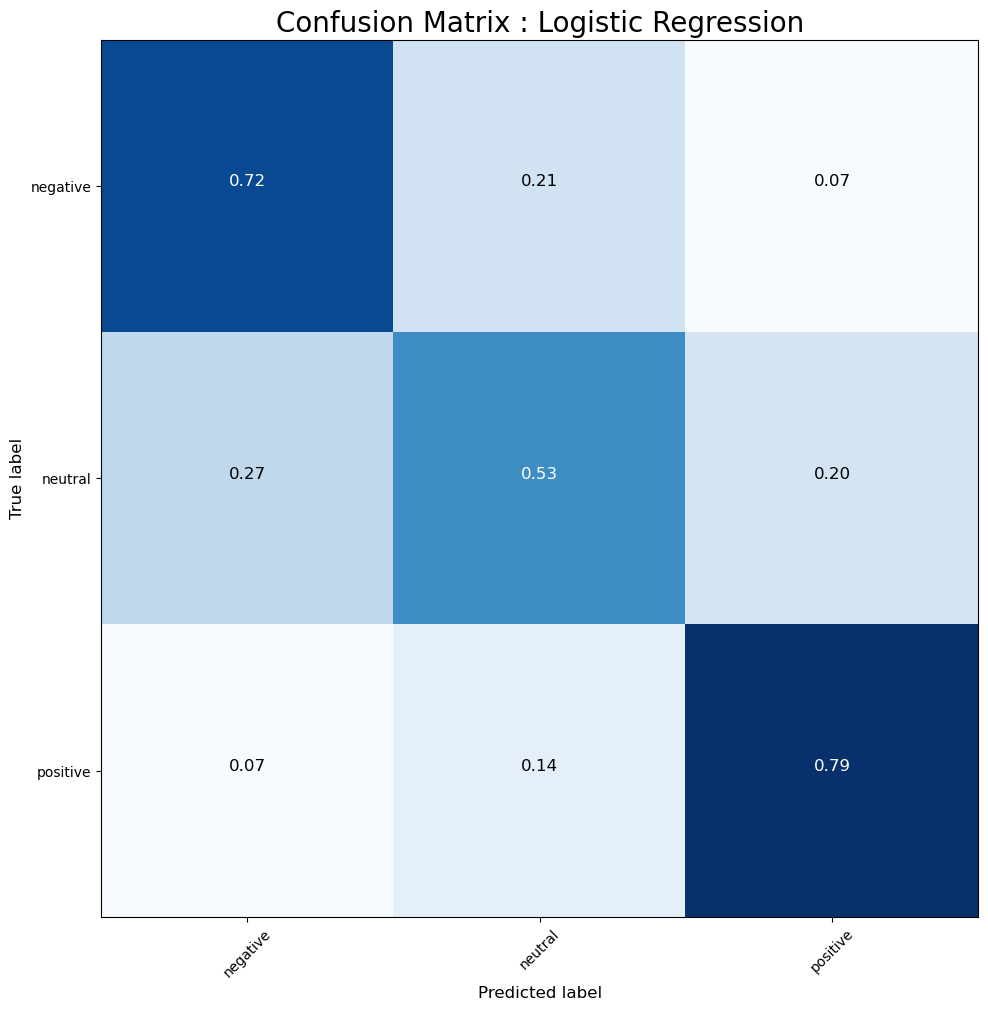

Training Set Classification Report: Linear Support Vector Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.66      0.72      0.69     41707
     neutral       0.33      0.35      0.34     20714
    positive       0.93      0.90      0.91    197241

    accuracy                           0.83    259662
   macro avg       0.64      0.66      0.65    259662
weighted avg       0.84      0.83      0.83    259662

Test Set Classification Report: Linear Support Vector Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.65      0.70      0.68     17803
     neutral       0.31      0.34      0.32      8826
    positive       0.92      0.90      0.91     84655

    accuracy                           0.82    111284
   macro avg       0.63      0.65      0.64    111284
weighted avg       0.83      0.82      0.83    111284

Confusion Matrix : Linear 

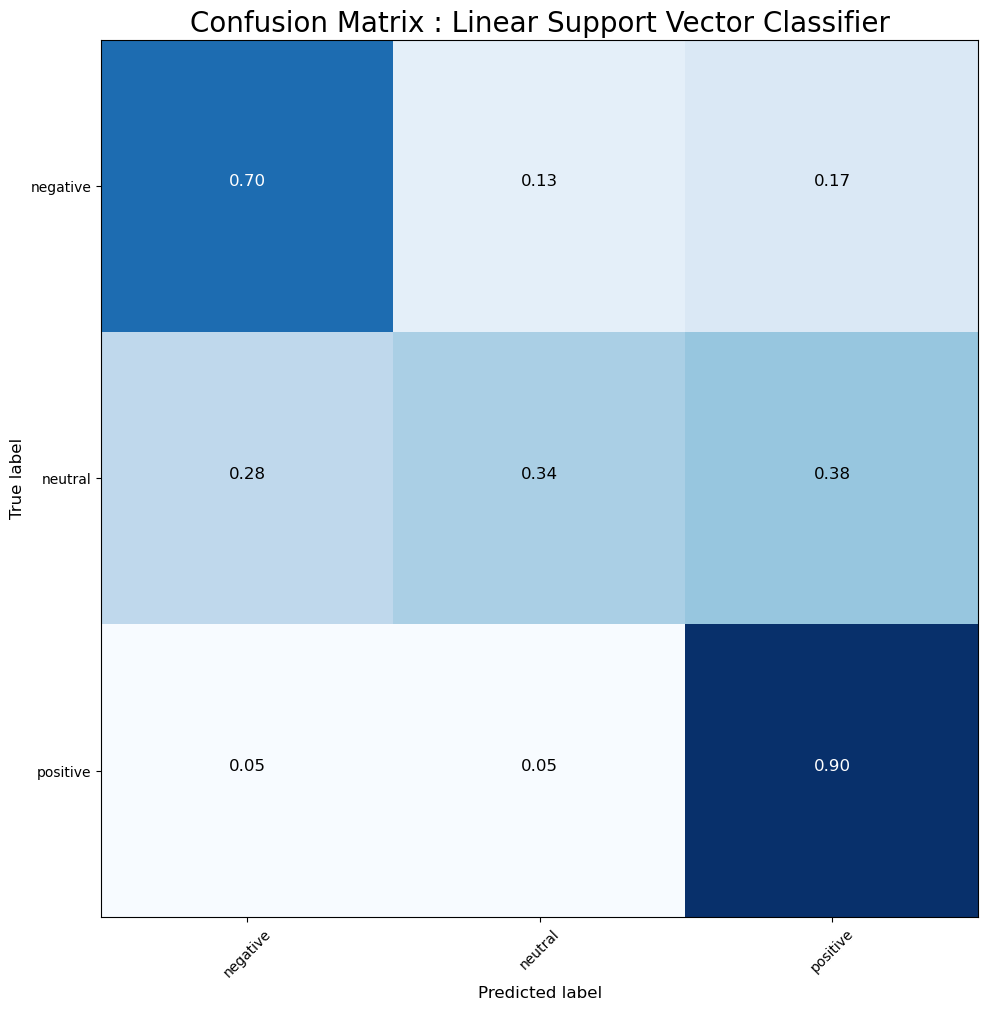

Training Set Classification Report: Random Forest

-------------------------------------
              precision    recall  f1-score   support

    negative       0.76      0.59      0.67     41707
     neutral       0.63      0.15      0.24     20714
    positive       0.87      0.98      0.92    197241

    accuracy                           0.85    259662
   macro avg       0.75      0.57      0.61    259662
weighted avg       0.83      0.85      0.82    259662

Test Set Classification Report: Random Forest

-------------------------------------
              precision    recall  f1-score   support

    negative       0.76      0.56      0.65     17803
     neutral       0.55      0.11      0.19      8826
    positive       0.86      0.98      0.91     84655

    accuracy                           0.84    111284
   macro avg       0.72      0.55      0.58    111284
weighted avg       0.82      0.84      0.81    111284

Confusion Matrix : Random Forest

------------------------------

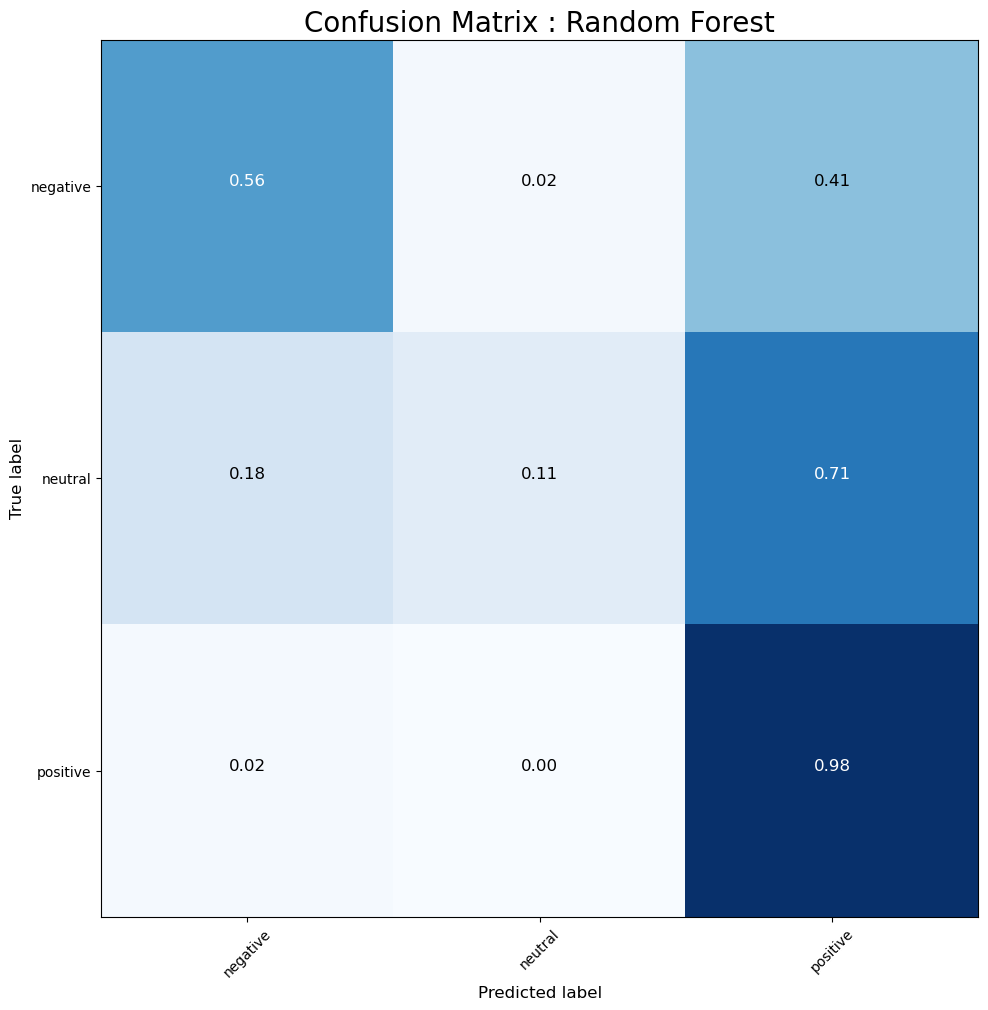

c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Set Classification Report: XGBoost Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.51      0.62     41707
     neutral       0.56      0.14      0.22     20714
    positive       0.85      0.98      0.91    197241

    accuracy                           0.84    259662
   macro avg       0.73      0.54      0.58    259662
weighted avg       0.82      0.84      0.81    259662



c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Set Classification Report: XGBoost Classifier

-------------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.52      0.62     17803
     neutral       0.53      0.12      0.20      8826
    positive       0.85      0.98      0.91     84655

    accuracy                           0.84    111284
   macro avg       0.72      0.54      0.58    111284
weighted avg       0.82      0.84      0.81    111284

Confusion Matrix : XGBoost Classifier

-------------------------------------


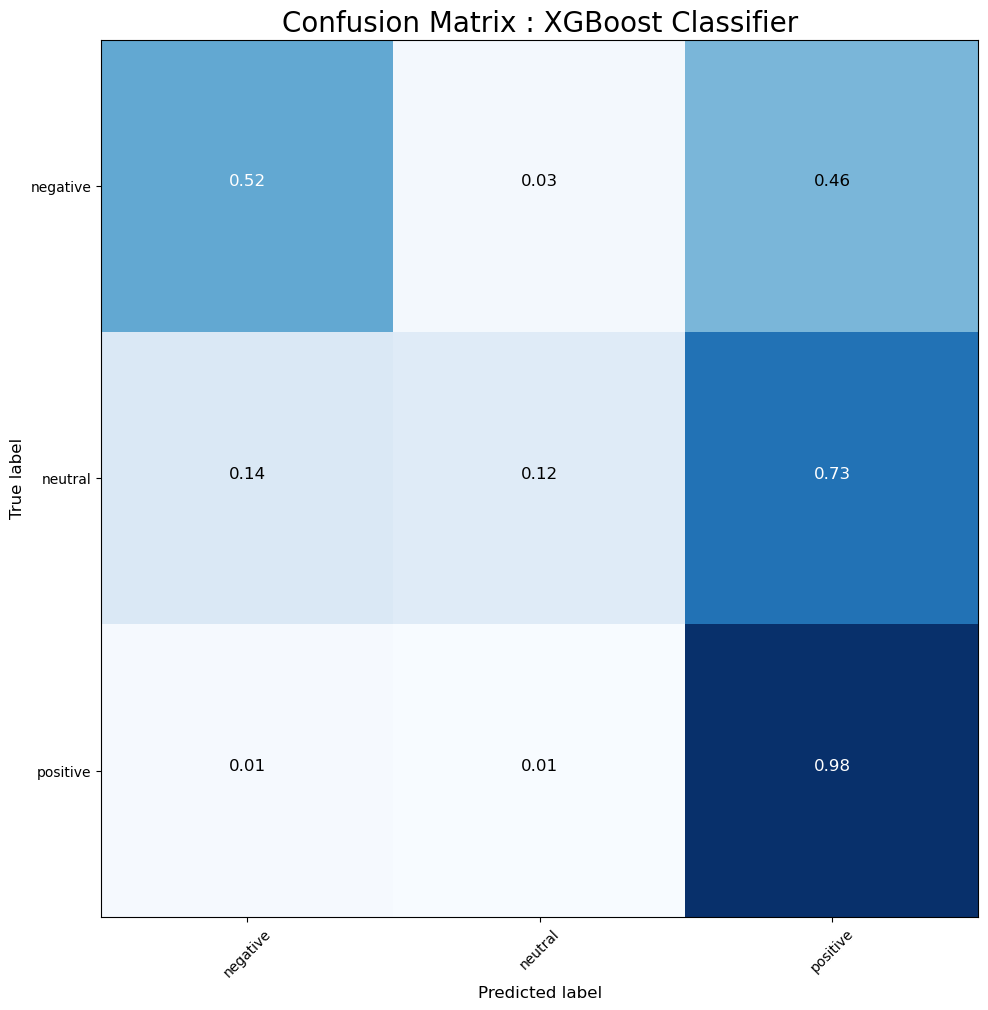

In [13]:
# set up loop to 

for model in models.items():
    
    # create the pipeline
    pipe = Pipeline([
        ('vec', tfidf_vec),
        ('clf', model[1])
    ])

    # print train classification report
    y_train_pred = cross_val_predict(pipe, X_train, y_train)
    print(f'Training Set Classification Report: {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_train, y_train_pred, target_names=TARGETS))

     # print test classification report
    y_test_pred = cross_val_predict(pipe, X_test, y_test)
    print(f'Test Set Classification Report: {model[0]}\n')
    print('-------------------------------------')
    print(classification_report(y_test, y_test_pred, target_names=TARGETS))

    # print confusion matrices
    print(f'Confusion Matrix : {model[0]}\n')
    print('-------------------------------------')
    plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=TARGETS, normalize=True, title=f'Confusion Matrix : {model[0]}')
    plt.grid(False)
    plt.savefig(f'../assets/tfidf_{model[0].replace(" ", "_").lower()}.png')
    plt.show()

In [98]:
# Multinomial NB w bag of words

cv= CountVectorizer(max_features=5000)
nb_bow_clf = MultinomialNB()
nb_bow_pipe = Pipeline([('vectorizer', cv), ('multinomialNB', nb_bow_clf)])
nb_bow_pipe.fit(X_train["lemma_sent"], y_train)


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=5000)),
                ('multinomialNB', MultinomialNB())])

In [99]:
# get preds 
nb_bow_train_pred = nb_bow_pipe.predict(X_train["lemma_sent"])
nb_bow_test_pred = nb_bow_pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, nb_bow_train_pred))
print(classification_report(y_test, nb_bow_test_pred))

              precision    recall  f1-score   support

           1       0.63      0.62      0.63     27595
           2       0.35      0.18      0.23     14112
           3       0.40      0.32      0.36     20714
           4       0.38      0.25      0.31     36765
           5       0.78      0.89      0.83    160476

    accuracy                           0.69    259662
   macro avg       0.51      0.45      0.47    259662
weighted avg       0.65      0.69      0.66    259662

              precision    recall  f1-score   support

           1       0.60      0.61      0.61     11630
           2       0.25      0.12      0.16      6173
           3       0.35      0.27      0.31      8826
           4       0.36      0.24      0.29     15870
           5       0.77      0.89      0.83     68785

    accuracy                           0.68    111284
   macro avg       0.47      0.43      0.44    111284
weighted avg       0.63      0.68      0.65    111284



In [106]:
# cross-val preds
nb_bow_cv_test_pred = cross_val_predict(nb_bow_pipe, X_test["lemma_sent"], y_test)
# print classification report
print(classification_report(y_test, nb_bow_cv_test_pred))

              precision    recall  f1-score   support

           1       0.60      0.59      0.59     11630
           2       0.22      0.11      0.15      6173
           3       0.34      0.25      0.29      8826
           4       0.35      0.24      0.29     15870
           5       0.77      0.89      0.82     68785

    accuracy                           0.67    111284
   macro avg       0.46      0.42      0.43    111284
weighted avg       0.63      0.67      0.64    111284



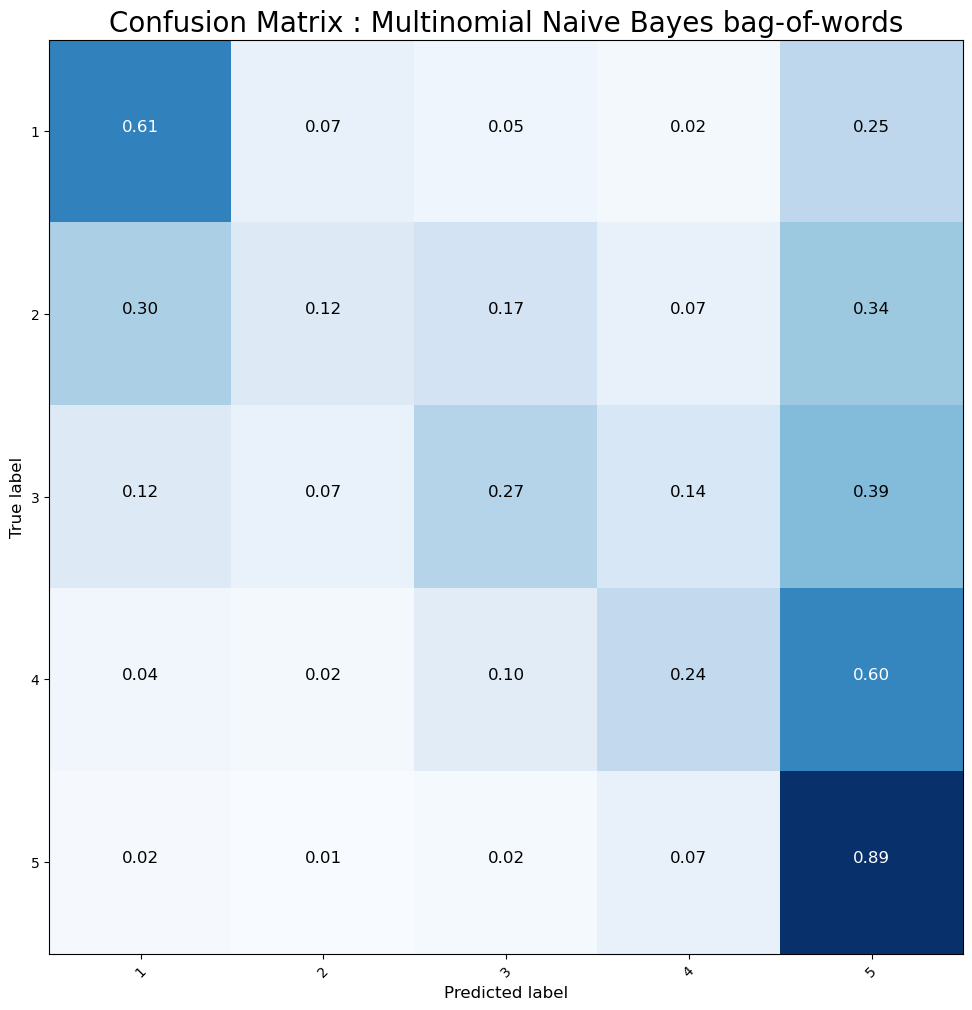

In [107]:
# confusion matrix for Multinomial Naive Bayes w/ bag of words

plot_confusion_matrix(confusion_matrix(y_test, nb_bow_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Multinomial Naive Bayes bag-of-words')

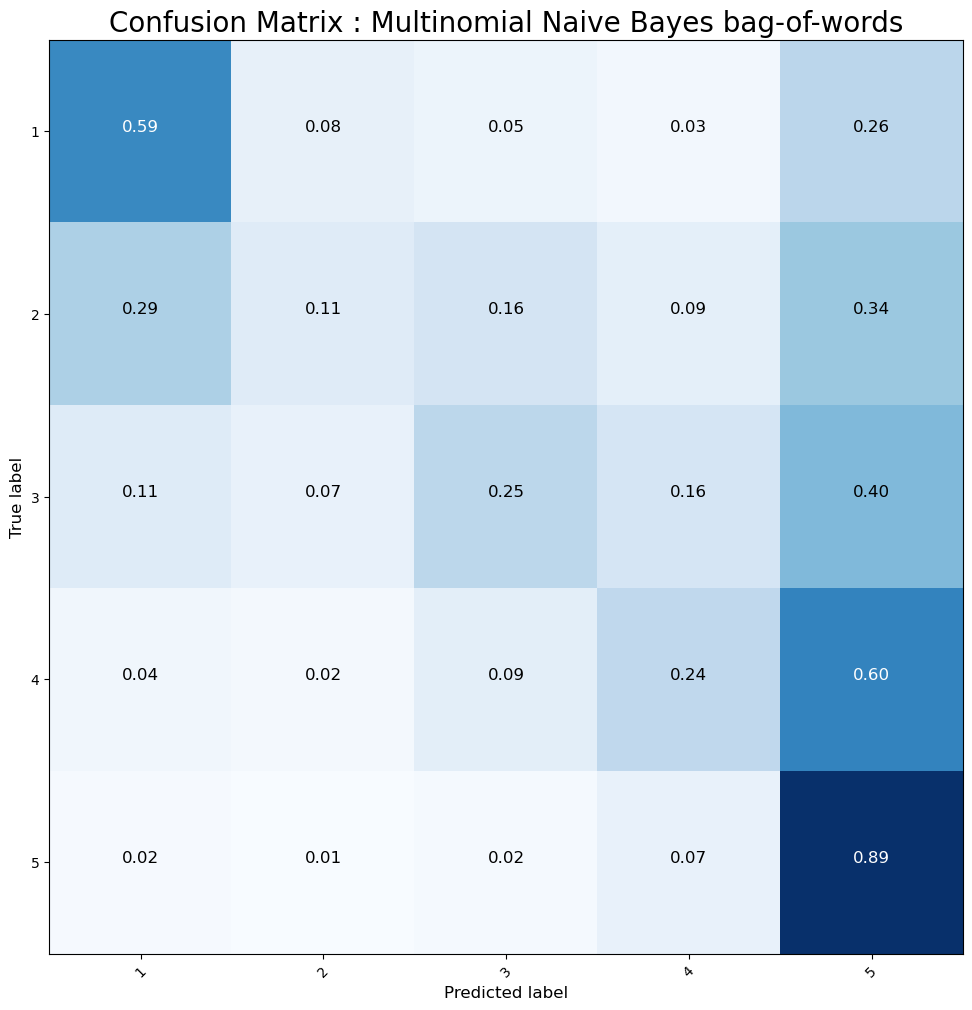

In [108]:
# confusion matrix for Multinomial Naive Bayes w/ bag of words (cross-validated preds)

plot_confusion_matrix(confusion_matrix(y_test, nb_bow_cv_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Multinomial Naive Bayes bag-of-words')

In [103]:
# logistic regression w bag of words

cv= CountVectorizer(max_features=5000)
log_bow_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_bow_pipe = Pipeline([('vectorizer', cv), ('Logistic Regression', log_bow_clf)])
log_bow_pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=5000)),
                ('Logistic Regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

              precision    recall  f1-score   support

           1       0.56      0.72      0.63     27595
           2       0.29      0.47      0.36     14112
           3       0.37      0.45      0.41     20714
           4       0.34      0.47      0.40     36765
           5       0.90      0.70      0.79    160476

    accuracy                           0.64    259662
   macro avg       0.49      0.56      0.52    259662
weighted avg       0.71      0.64      0.66    259662

              precision    recall  f1-score   support

           1       0.51      0.67      0.58     11630
           2       0.21      0.33      0.25      6173
           3       0.29      0.36      0.32      8826
           4       0.30      0.41      0.34     15870
           5       0.89      0.69      0.78     68785

    accuracy                           0.60    111284
   macro avg       0.44      0.49      0.45    111284
weighted avg       0.68      0.60      0.63    111284



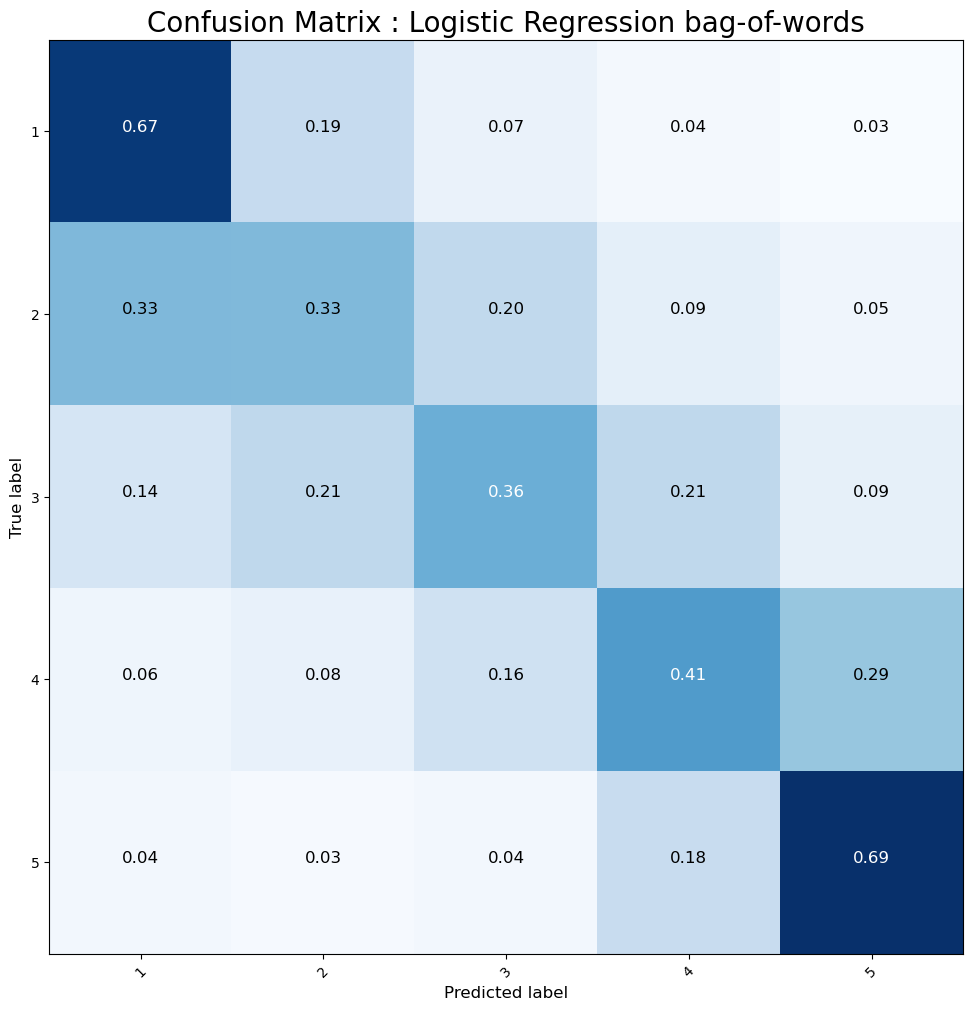

In [109]:
# create preds from pipeline model
log_bow_train_pred = log_bow_pipe.predict(X_train["lemma_sent"])
log_bow_test_pred = log_bow_pipe.predict(X_test["lemma_sent"])

# print classification report
print(classification_report(y_train, log_bow_train_pred))
print(classification_report(y_test, log_bow_test_pred))

# confusion matrix for Logistic Regression w/ bag of words 
plot_confusion_matrix(confusion_matrix(y_test, log_bow_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Logistic Regression bag-of-words')

              precision    recall  f1-score   support

           1       0.50      0.63      0.56     11630
           2       0.19      0.29      0.23      6173
           3       0.26      0.35      0.30      8826
           4       0.29      0.39      0.33     15870
           5       0.88      0.69      0.77     68785

    accuracy                           0.59    111284
   macro avg       0.42      0.47      0.44    111284
weighted avg       0.67      0.59      0.62    111284



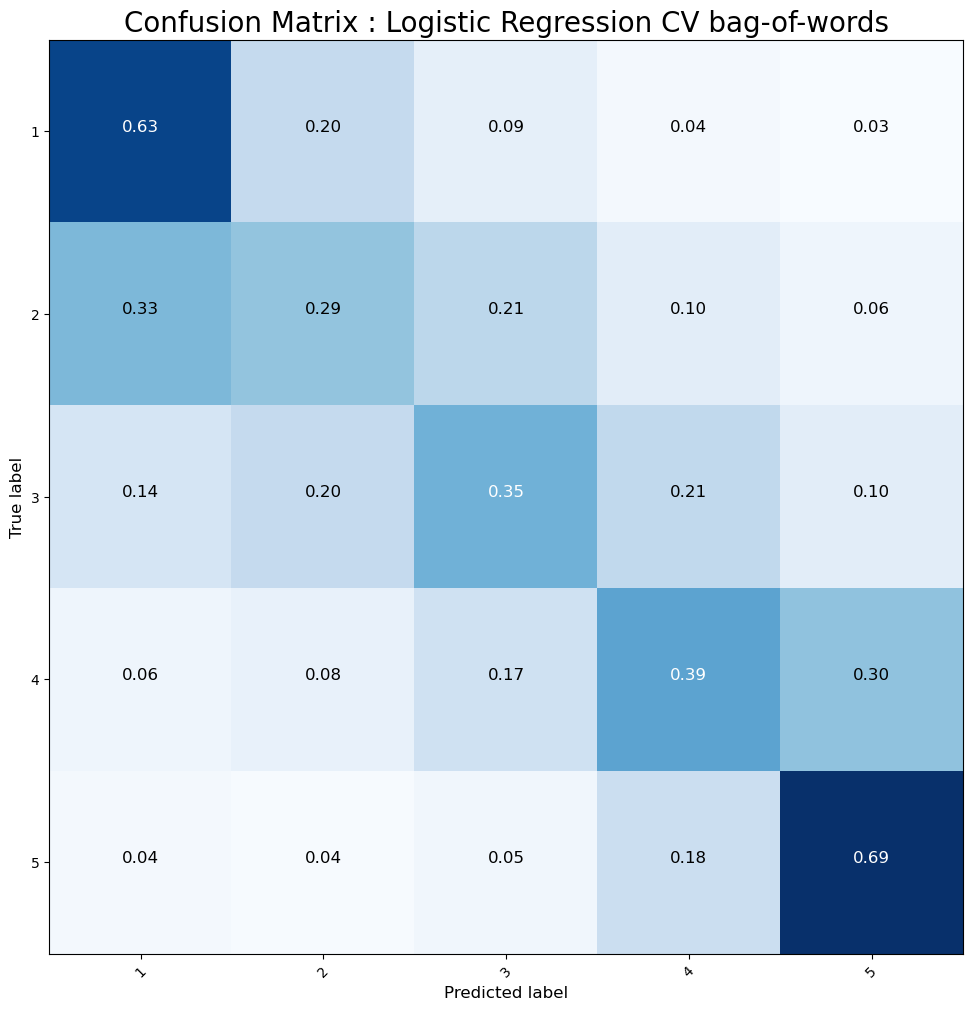

In [110]:
# cross-val preds
log_bow_cv_test_pred = cross_val_predict(log_bow_pipe, X_test["lemma_sent"], y_test)

# print classification report
print(classification_report(y_test, log_bow_cv_test_pred))

# confusion matrix for Logistic Regression w/ bag of words (cross-val preds)
plot_confusion_matrix(confusion_matrix(y_test, log_bow_cv_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Logistic Regression CV bag-of-words')

In [42]:
# linear SVC w bag of words

cv= CountVectorizer(max_features=5000)
svc_bow_clf = LinearSVC(class_weight='balanced', max_iter=MAX_FEAT)
svc_bow_pipe = Pipeline([('vectorizer', cv), ('Linear SVC', svc_bow_clf)])
svc_bow_pipe.fit(X_train["lemma_sent"], y_train)

c:\Users\bosea\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=5000)),
                ('Linear SVC',
                 LinearSVC(class_weight='balanced', max_iter=5000))])

In [43]:
# create preds from pipeline model
svc_train_pred = pipe.predict(X_train["lemma_sent"])
svc_test_pred = pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, svc_train_pred))
print(classification_report(y_test, svc_test_pred))

              precision    recall  f1-score   support

           1       0.60      0.74      0.66     27595
           2       0.31      0.33      0.32     14112
           3       0.42      0.39      0.40     20714
           4       0.47      0.27      0.35     36765
           5       0.83      0.88      0.86    160476

    accuracy                           0.71    259662
   macro avg       0.53      0.52      0.52    259662
weighted avg       0.69      0.71      0.70    259662

              precision    recall  f1-score   support

           1       0.55      0.70      0.61     11630
           2       0.22      0.22      0.22      6173
           3       0.34      0.31      0.33      8826
           4       0.40      0.23      0.29     15870
           5       0.82      0.87      0.85     68785

    accuracy                           0.68    111284
   macro avg       0.47      0.47      0.46    111284
weighted avg       0.66      0.68      0.67    111284



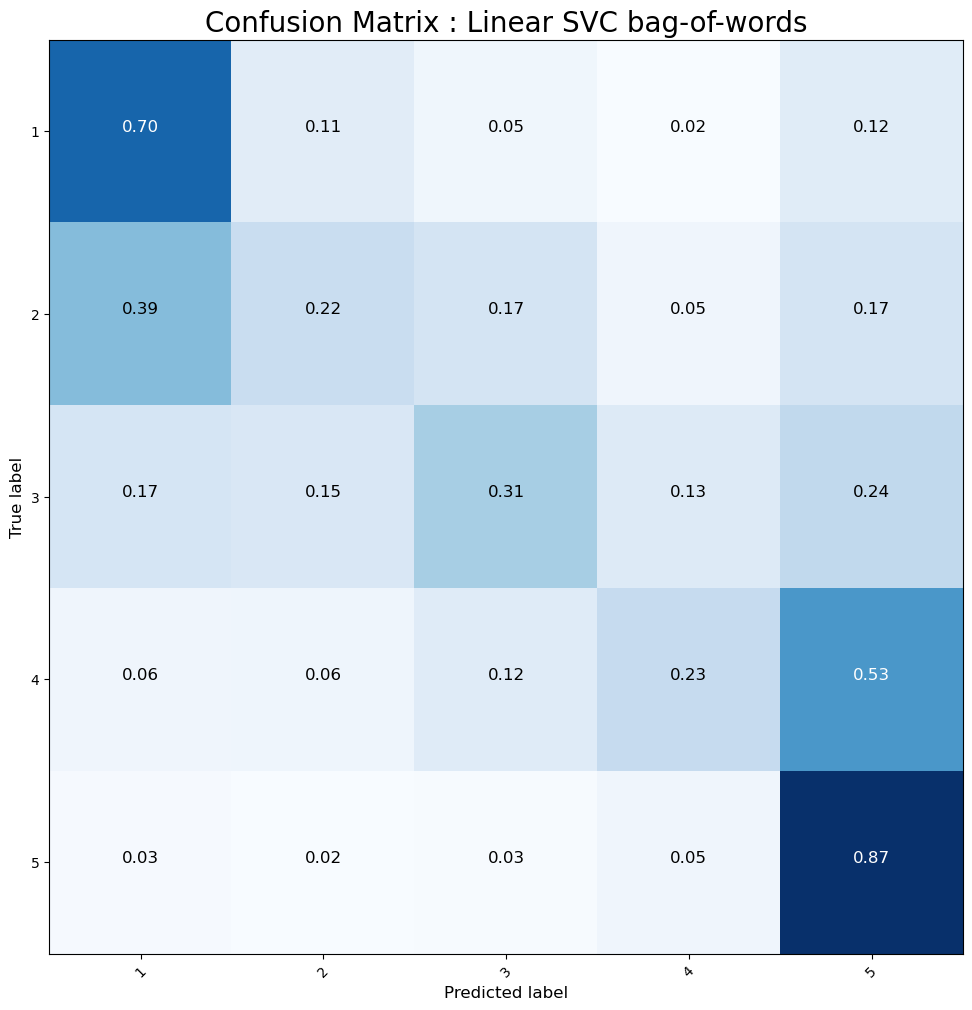

In [92]:
# confusion matrix for Linear SVC w/ bag of words

plot_confusion_matrix(confusion_matrix(y_test, svc_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Linear SVC bag-of-words')

In [46]:
# RF model w bag of words

cv= CountVectorizer(max_features=5000)
clf = RandomForestClassifier(random_state=42)
pipe = Pipeline([('vectorizer', cv), ('Random Forest Classifier', clf)])
pipe.fit(X_train["lemma_sent"], y_train)


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=5000)),
                ('Random Forest Classifier',
                 RandomForestClassifier(random_state=42))])

In [47]:
# create preds from pipeline model
rf_train_pred = pipe.predict(X_train["lemma_sent"])
rf_test_pred = pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, rf_train_pred))
print(classification_report(y_test, rf_test_pred))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97     27595
           2       0.98      0.94      0.96     14112
           3       0.97      0.95      0.96     20714
           4       0.99      0.90      0.95     36765
           5       0.97      1.00      0.98    160476

    accuracy                           0.97    259662
   macro avg       0.98      0.95      0.96    259662
weighted avg       0.97      0.97      0.97    259662

              precision    recall  f1-score   support

           1       0.61      0.63      0.62     11630
           2       0.40      0.09      0.15      6173
           3       0.51      0.23      0.32      8826
           4       0.54      0.16      0.24     15870
           5       0.74      0.96      0.84     68785

    accuracy                           0.71    111284
   macro avg       0.56      0.42      0.43    111284
weighted avg       0.66      0.71      0.65    111284



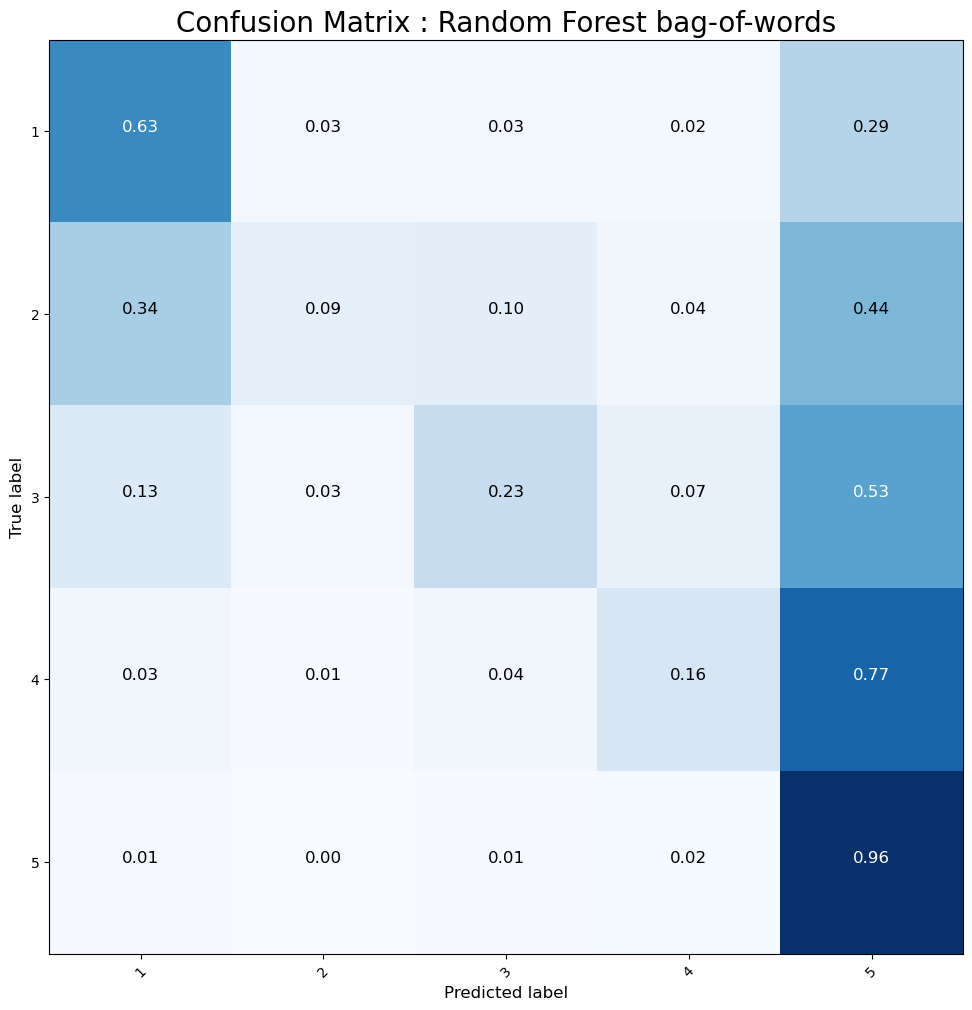

In [91]:
# confusion matrix for Random Forest w/ bag of words

plot_confusion_matrix(confusion_matrix(y_test, rf_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Random Forest bag-of-words')

In [49]:
# XGBoost model w bag of words
cv= CountVectorizer(max_features=5000)
clf = XGBClassifier(random_state=42, seed=42)
pipe = Pipeline([('vectorizer', cv), ('XGBoost Classifier', clf)])
pipe.fit(X_train["lemma_sent"], y_train)

c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('vectorizer', CountVectorizer(max_features=5000)),
                ('XGBoost Classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, seed=42, subsample=1,
                           

In [50]:
# create preds from pipeline model
xgb_train_pred = pipe.predict(X_train["lemma_sent"])
xgb_test_pred = pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, xgb_train_pred))
print(classification_report(y_test, xgb_test_pred))

              precision    recall  f1-score   support

           1       0.71      0.55      0.62     27595
           2       0.75      0.11      0.18     14112
           3       0.61      0.25      0.35     20714
           4       0.63      0.18      0.28     36765
           5       0.72      0.98      0.83    160476

    accuracy                           0.71    259662
   macro avg       0.68      0.41      0.45    259662
weighted avg       0.70      0.71      0.66    259662

              precision    recall  f1-score   support

           1       0.66      0.53      0.59     11630
           2       0.34      0.04      0.07      6173
           3       0.48      0.19      0.27      8826
           4       0.49      0.14      0.21     15870
           5       0.71      0.97      0.82     68785

    accuracy                           0.69    111284
   macro avg       0.54      0.37      0.39    111284
weighted avg       0.64      0.69      0.63    111284



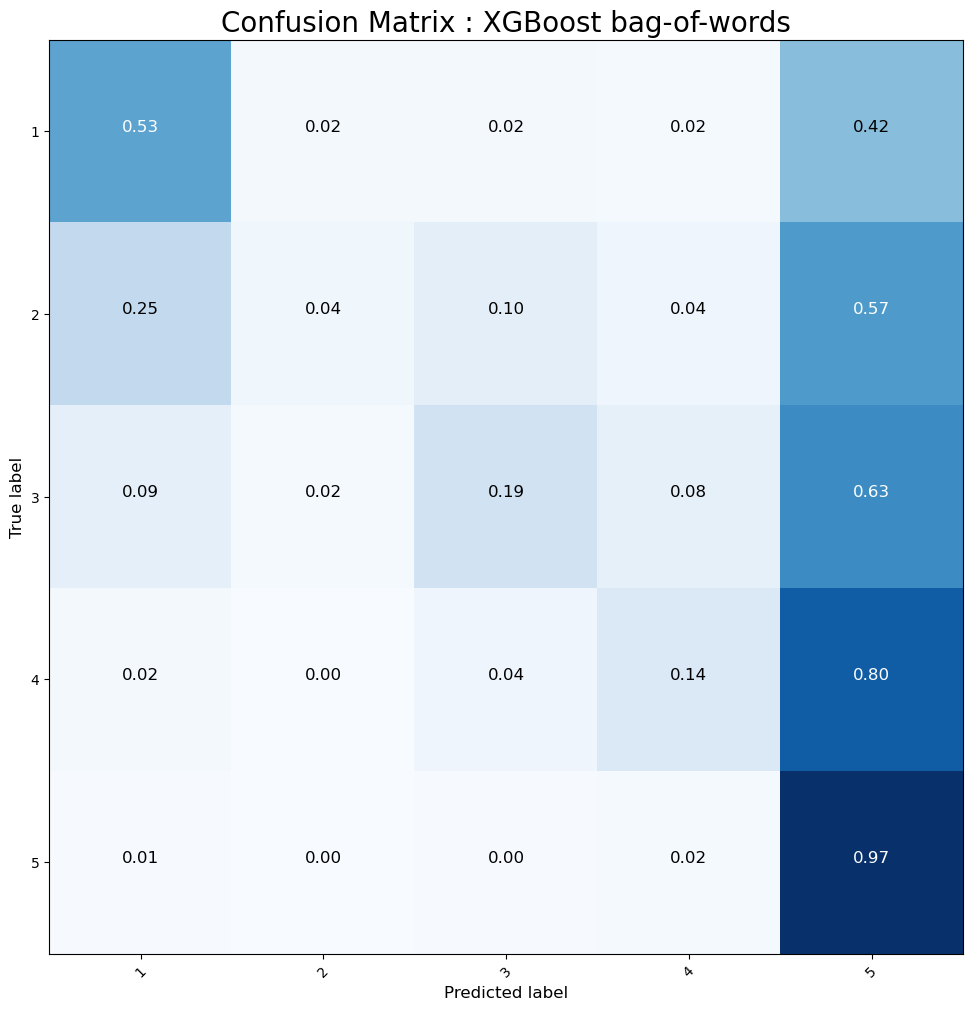

In [90]:
# confusion matrix for XGBoost w/ bag of words

plot_confusion_matrix(confusion_matrix(y_test, xgb_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : XGBoost bag-of-words')

#### Bag of n-grams models

In [44]:
# multinomial NB model w n-grams

cv= CountVectorizer(max_features=MAX_FEAT, ngram_range=(1, 3))
clf = MultinomialNB()
pipe = Pipeline([('vectorizer', cv), ('multinomialNB', clf)])
pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('multinomialNB', MultinomialNB())])

In [45]:
# get preds and classification report

nb_ngram_train_pred = pipe.predict(X_train["lemma_sent"])
nb_ngram_test_pred = pipe.predict(X_test["lemma_sent"])

print(classification_report(y_train, nb_ngram_train_pred))
print(classification_report(y_test, nb_ngram_test_pred))

              precision    recall  f1-score   support

           1       0.60      0.66      0.63     27595
           2       0.31      0.21      0.26     14112
           3       0.37      0.36      0.37     20714
           4       0.37      0.31      0.34     36765
           5       0.80      0.85      0.83    160476

    accuracy                           0.68    259662
   macro avg       0.49      0.48      0.48    259662
weighted avg       0.66      0.68      0.67    259662

              precision    recall  f1-score   support

           1       0.57      0.65      0.61     11630
           2       0.24      0.16      0.19      6173
           3       0.33      0.31      0.32      8826
           4       0.35      0.29      0.32     15870
           5       0.80      0.84      0.82     68785

    accuracy                           0.66    111284
   macro avg       0.46      0.45      0.45    111284
weighted avg       0.64      0.66      0.65    111284



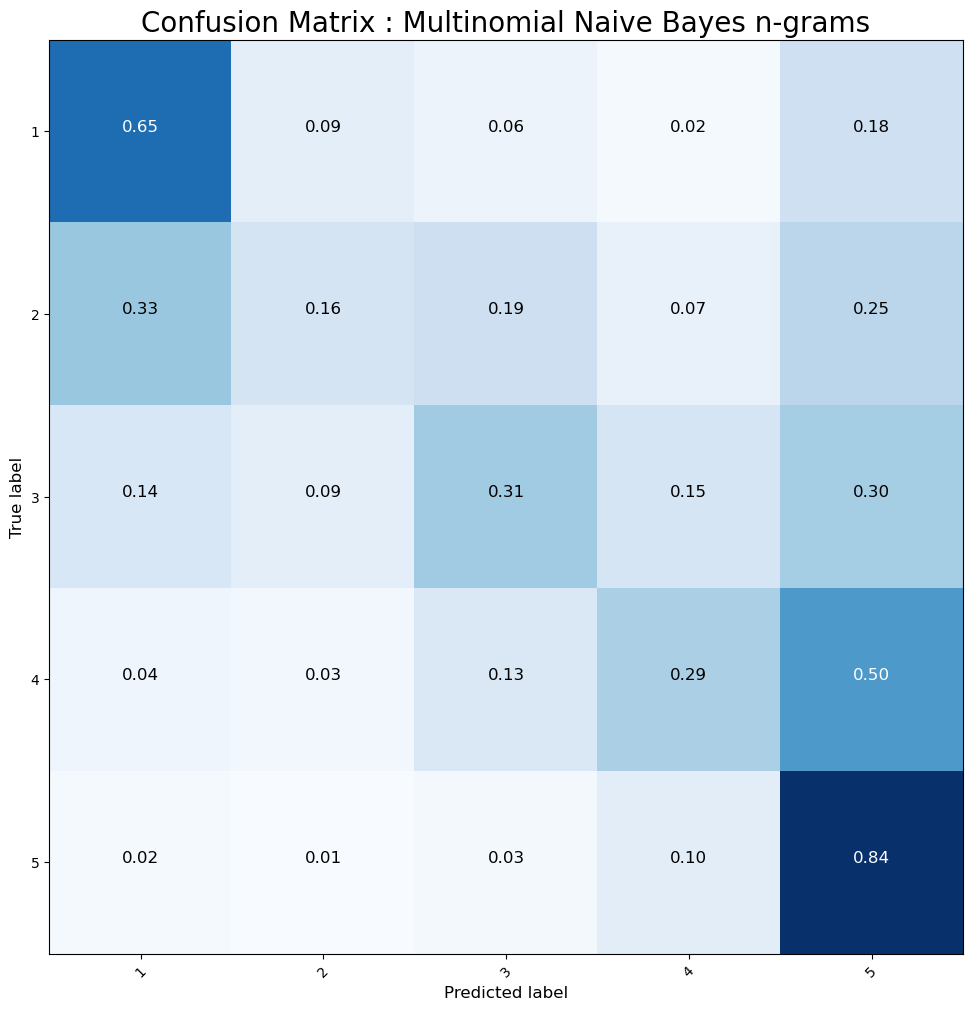

In [88]:
# confusion matrix for Multinomial Naive Bayes w/ n-grams

plot_confusion_matrix(confusion_matrix(y_test, nb_ngram_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Multinomial Naive Bayes n-grams')

In [52]:
# logistic regression with n-grams

cv= CountVectorizer(max_features=MAX_FEAT, ngram_range=(1, 3))
log_ngram_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
pipe = Pipeline([('vectorizer', cv), ('Logistic Regression', log_ngram_clf)])
pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('Logistic Regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [53]:
# get preds and classification report

log_ngram_train_pred = pipe.predict(X_train["lemma_sent"])
log_ngram_test_pred = pipe.predict(X_test["lemma_sent"])

print(classification_report(y_train, log_ngram_train_pred))
print(classification_report(y_test, log_ngram_test_pred))

              precision    recall  f1-score   support

           1       0.57      0.71      0.63     27595
           2       0.28      0.49      0.36     14112
           3       0.36      0.47      0.41     20714
           4       0.34      0.48      0.40     36765
           5       0.91      0.69      0.78    160476

    accuracy                           0.63    259662
   macro avg       0.49      0.57      0.52    259662
weighted avg       0.71      0.63      0.66    259662

              precision    recall  f1-score   support

           1       0.52      0.66      0.58     11630
           2       0.20      0.34      0.25      6173
           3       0.28      0.37      0.32      8826
           4       0.30      0.42      0.35     15870
           5       0.89      0.68      0.77     68785

    accuracy                           0.60    111284
   macro avg       0.44      0.49      0.45    111284
weighted avg       0.68      0.60      0.63    111284



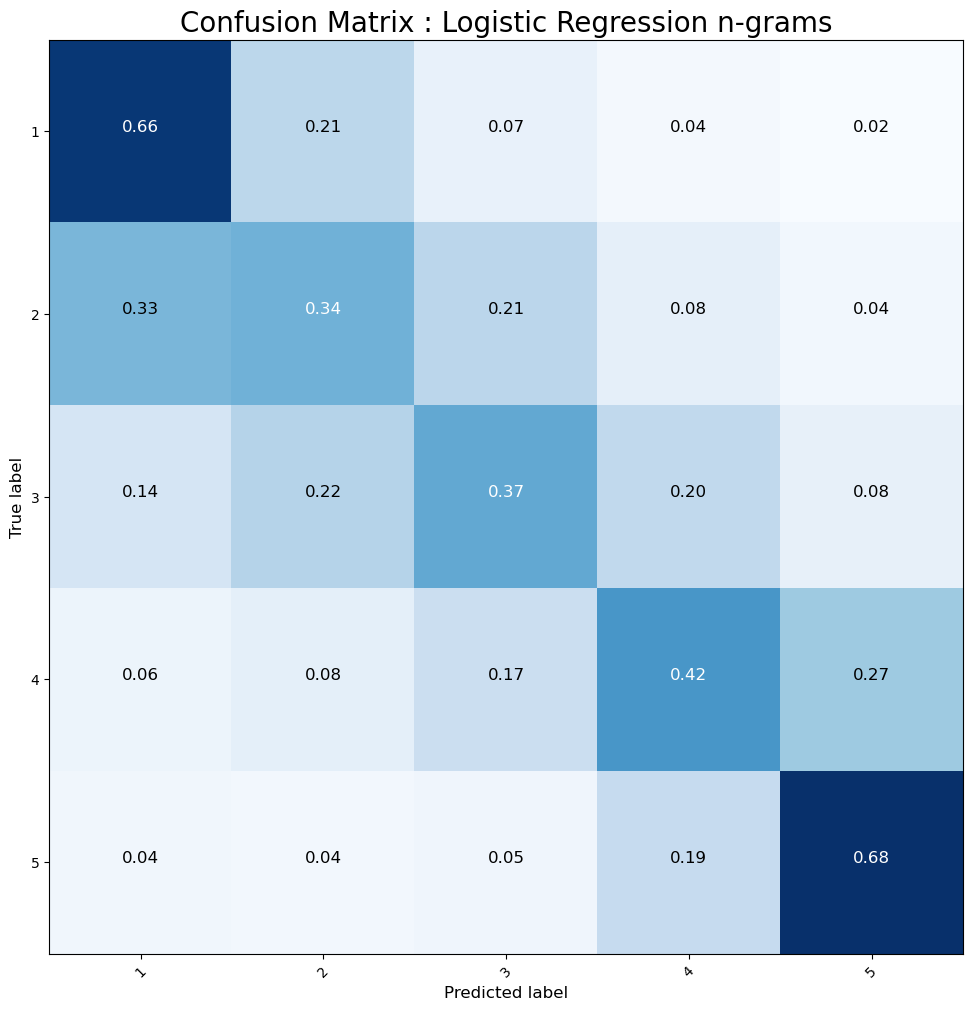

In [87]:
# confusion matrix for Logistic Regression w/ n-grams

plot_confusion_matrix(confusion_matrix(y_test, log_ngram_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Logistic Regression n-grams')

In [54]:
# SVC w n-grams

cv= CountVectorizer(max_features=MAX_FEAT, ngram_range=(1, 3))
svc_ngram_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
svc_ngram_pipe = Pipeline([('vectorizer', cv), ('Linear SVC', svc_ngram_clf)])
svc_ngram_pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('Linear SVC',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [57]:
# get preds and classification report

svc_ngram_train_pred = svc_ngram_pipe.predict(X_train["lemma_sent"])
svc_ngram_test_pred = svc_ngram_pipe.predict(X_test["lemma_sent"])

print(classification_report(y_train, svc_ngram_train_pred))
print(classification_report(y_test, svc_ngram_test_pred))

              precision    recall  f1-score   support

           1       0.57      0.71      0.63     27595
           2       0.28      0.49      0.36     14112
           3       0.36      0.47      0.41     20714
           4       0.34      0.48      0.40     36765
           5       0.91      0.69      0.78    160476

    accuracy                           0.63    259662
   macro avg       0.49      0.57      0.52    259662
weighted avg       0.71      0.63      0.66    259662

              precision    recall  f1-score   support

           1       0.52      0.66      0.58     11630
           2       0.20      0.34      0.25      6173
           3       0.28      0.37      0.32      8826
           4       0.30      0.42      0.35     15870
           5       0.89      0.68      0.77     68785

    accuracy                           0.60    111284
   macro avg       0.44      0.49      0.45    111284
weighted avg       0.68      0.60      0.63    111284



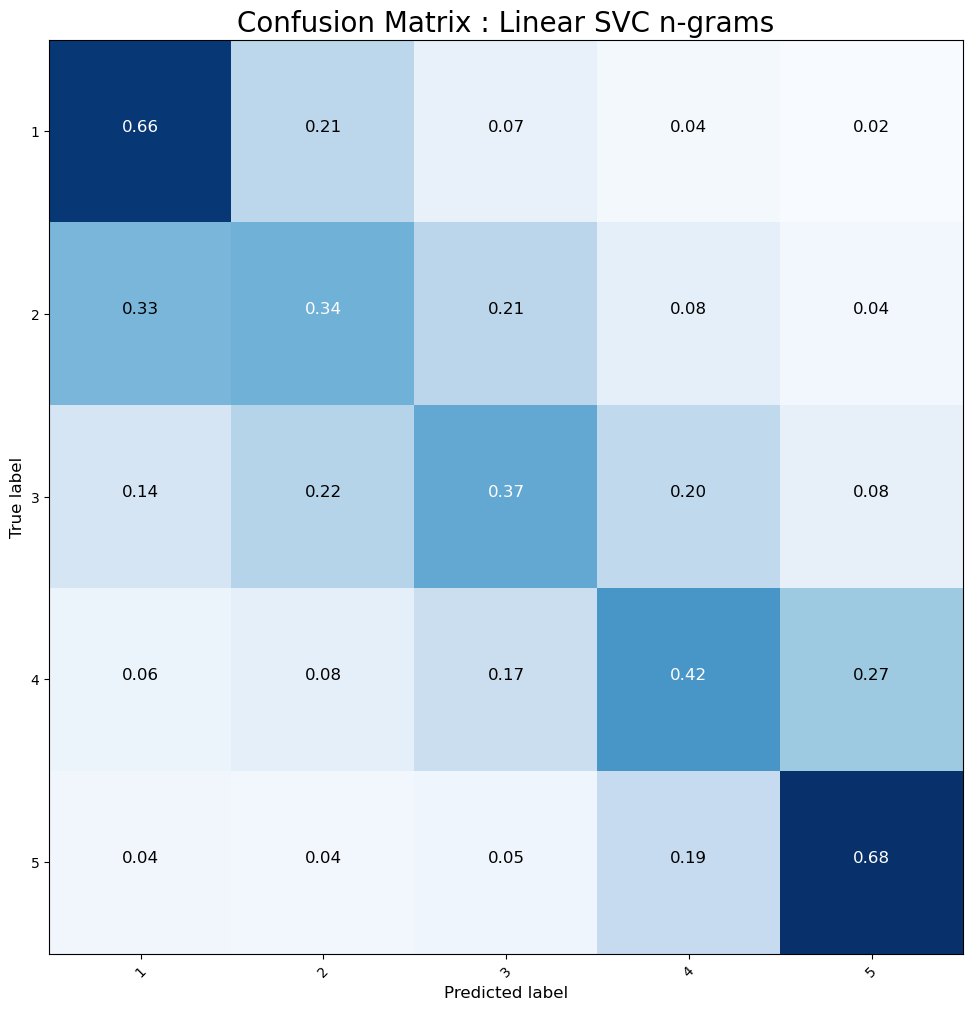

In [86]:
# confusion matrix for Linear SVC w/ n-grams

plot_confusion_matrix(confusion_matrix(y_test, svc_ngram_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Linear SVC n-grams')

In [56]:
# RF w n-grams

cv= CountVectorizer(max_features=MAX_FEAT, ngram_range=(1, 3))
rf_ngram_clf = RandomForestClassifier(random_state=42)
rf_ngram_pipe = Pipeline([('vectorizer', cv), ('Random Forest', rf_ngram_clf)])
rf_ngram_pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('Random Forest', RandomForestClassifier(random_state=42))])

In [58]:
# get preds and classification report

rf_ngram_train_pred = rf_ngram_pipe.predict(X_train["lemma_sent"])
rf_ngram_test_pred = rf_ngram_pipe.predict(X_test["lemma_sent"])

print(classification_report(y_train, rf_ngram_train_pred))
print(classification_report(y_test, rf_ngram_test_pred))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97     27595
           2       0.98      0.94      0.96     14112
           3       0.97      0.95      0.96     20714
           4       0.99      0.90      0.95     36765
           5       0.97      1.00      0.98    160476

    accuracy                           0.97    259662
   macro avg       0.98      0.95      0.96    259662
weighted avg       0.97      0.97      0.97    259662

              precision    recall  f1-score   support

           1       0.61      0.65      0.62     11630
           2       0.39      0.09      0.15      6173
           3       0.50      0.24      0.32      8826
           4       0.56      0.17      0.26     15870
           5       0.75      0.96      0.84     68785

    accuracy                           0.71    111284
   macro avg       0.56      0.42      0.44    111284
weighted avg       0.67      0.71      0.66    111284



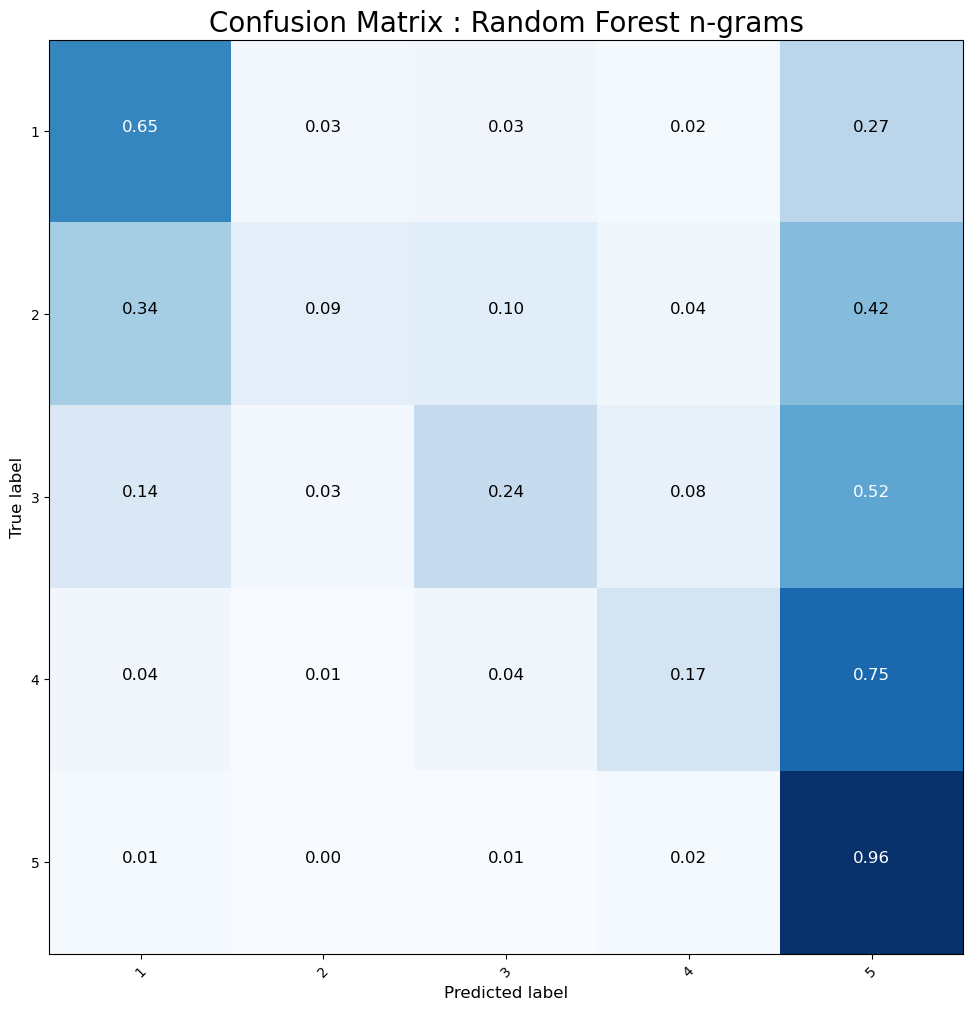

In [81]:
# confusion matrix for Random Forest w/ n-grams

plot_confusion_matrix(confusion_matrix(y_test, rf_ngram_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Random Forest n-grams')

In [59]:
# XGBoost w n-grams

cv= CountVectorizer(max_features=MAX_FEAT, ngram_range=(1, 3))
xgb_ngram_clf = XGBClassifier(random_state=42, seed=42)
xgb_ngram_pipe = Pipeline([('vectorizer', cv), ('Random Forest', xgb_ngram_clf)])
xgb_ngram_pipe.fit(X_train["lemma_sent"], y_train)

c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:36:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=5000, ngram_range=(1, 3))),
                ('Random Forest',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, seed=42, subsampl

In [60]:
# create preds from pipeline model
xgb_ngram_train_pred = xgb_ngram_pipe.predict(X_train["lemma_sent"])
xgb_ngram_test_pred = xgb_ngram_pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, xgb_ngram_train_pred))
print(classification_report(y_test, xgb_ngram_test_pred))

              precision    recall  f1-score   support

           1       0.71      0.55      0.62     27595
           2       0.75      0.10      0.18     14112
           3       0.60      0.24      0.35     20714
           4       0.63      0.18      0.28     36765
           5       0.72      0.98      0.83    160476

    accuracy                           0.72    259662
   macro avg       0.68      0.41      0.45    259662
weighted avg       0.70      0.72      0.66    259662

              precision    recall  f1-score   support

           1       0.67      0.54      0.60     11630
           2       0.33      0.04      0.07      6173
           3       0.47      0.18      0.26      8826
           4       0.50      0.14      0.22     15870
           5       0.72      0.97      0.83     68785

    accuracy                           0.69    111284
   macro avg       0.54      0.37      0.39    111284
weighted avg       0.64      0.69      0.63    111284



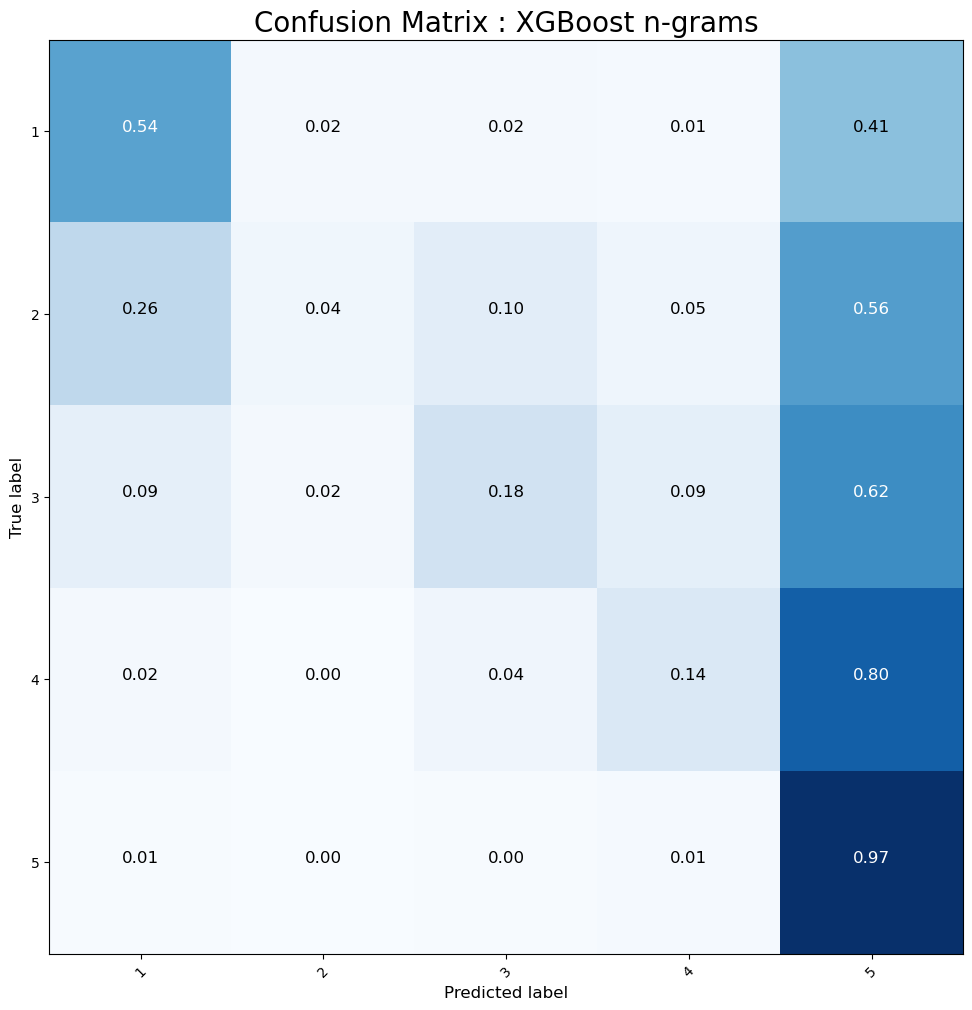

In [80]:
# confusion matrix for XGBoost w/ n-grams

plot_confusion_matrix(confusion_matrix(y_test, xgb_ngram_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : XGBoost n-grams')

#### TF-IDF models

In [61]:
# multinomial NB model w TF-IDF

tfidf_vec= TfidfVectorizer(max_features=MAX_FEAT)
clf = MultinomialNB()
nb_tfidf_pipe = Pipeline([('vectorizer', tfidf_vec), ('multinomialNB', clf)])
nb_tfidf_pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=5000)),
                ('multinomialNB', MultinomialNB())])

In [62]:
# create preds from pipeline model
nb_tfidf_train_pred = nb_tfidf_pipe.predict(X_train["lemma_sent"])
nb_tfidf_test_pred = nb_tfidf_pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, nb_tfidf_train_pred))
print(classification_report(y_test, nb_tfidf_test_pred))

              precision    recall  f1-score   support

           1       0.72      0.45      0.56     27595
           2       0.58      0.01      0.01     14112
           3       0.54      0.09      0.16     20714
           4       0.44      0.05      0.10     36765
           5       0.68      0.99      0.80    160476

    accuracy                           0.67    259662
   macro avg       0.59      0.32      0.33    259662
weighted avg       0.63      0.67      0.58    259662

              precision    recall  f1-score   support

           1       0.70      0.45      0.55     11630
           2       0.42      0.00      0.01      6173
           3       0.46      0.07      0.13      8826
           4       0.43      0.05      0.09     15870
           5       0.68      0.99      0.80     68785

    accuracy                           0.67    111284
   macro avg       0.54      0.31      0.31    111284
weighted avg       0.61      0.67      0.58    111284



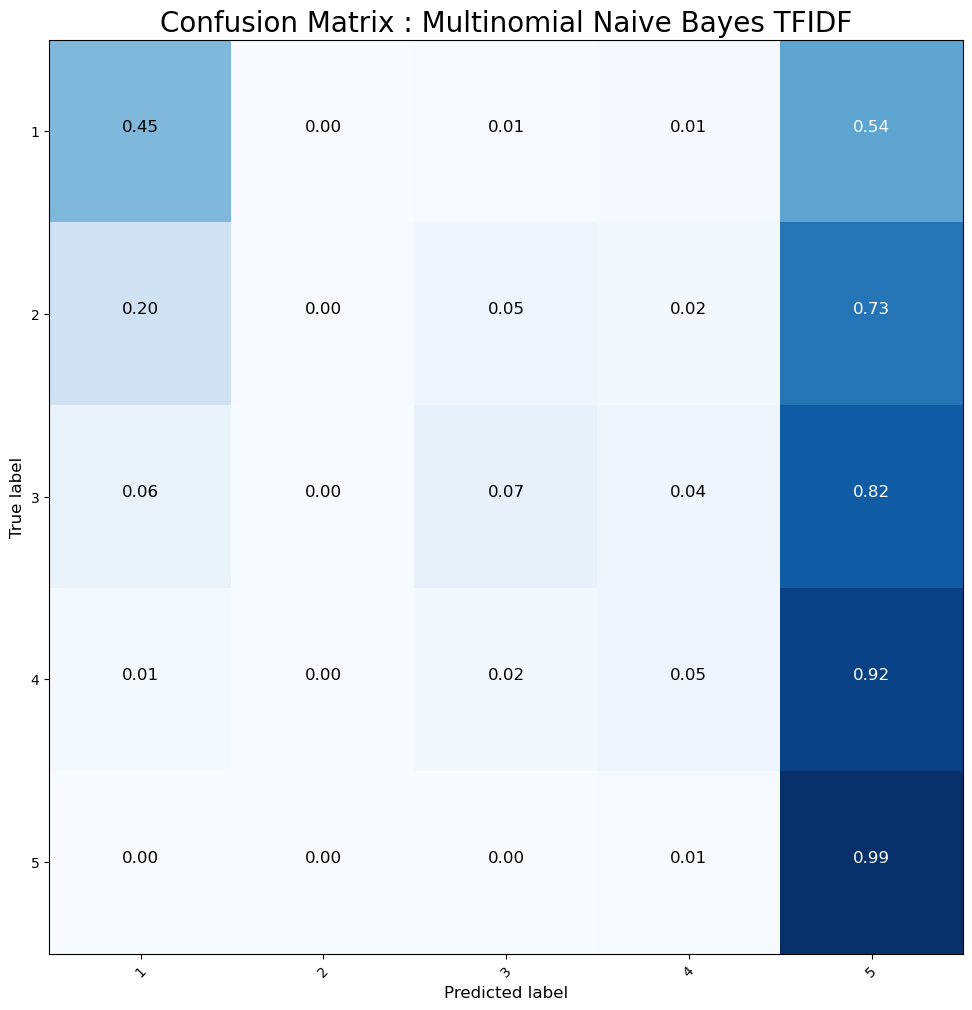

In [85]:
# confusion matrix for multinomial NB w/ TF-IDF

plot_confusion_matrix(confusion_matrix(y_test, nb_tfidf_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Multinomial Naive Bayes TFIDF')

In [63]:
# logistic regression model w TF-IDF

tfidf_vec= TfidfVectorizer(max_features=MAX_FEAT)
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_tfidf_pipe = Pipeline([('vectorizer', tfidf_vec), ('Logistic Regression', clf)])
log_tfidf_pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=5000)),
                ('Logistic Regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [64]:
# create preds from pipeline model
log_tfidf_train_pred = log_tfidf_pipe.predict(X_train["lemma_sent"])
log_tfidf_test_pred = log_tfidf_pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, log_tfidf_train_pred))
print(classification_report(y_test, log_tfidf_test_pred))

              precision    recall  f1-score   support

           1       0.59      0.68      0.63     27595
           2       0.27      0.49      0.35     14112
           3       0.35      0.47      0.40     20714
           4       0.33      0.48      0.39     36765
           5       0.91      0.68      0.78    160476

    accuracy                           0.63    259662
   macro avg       0.49      0.56      0.51    259662
weighted avg       0.71      0.63      0.65    259662

              precision    recall  f1-score   support

           1       0.54      0.64      0.59     11630
           2       0.20      0.36      0.26      6173
           3       0.28      0.38      0.32      8826
           4       0.29      0.43      0.35     15870
           5       0.90      0.67      0.77     68785

    accuracy                           0.59    111284
   macro avg       0.44      0.49      0.46    111284
weighted avg       0.69      0.59      0.63    111284



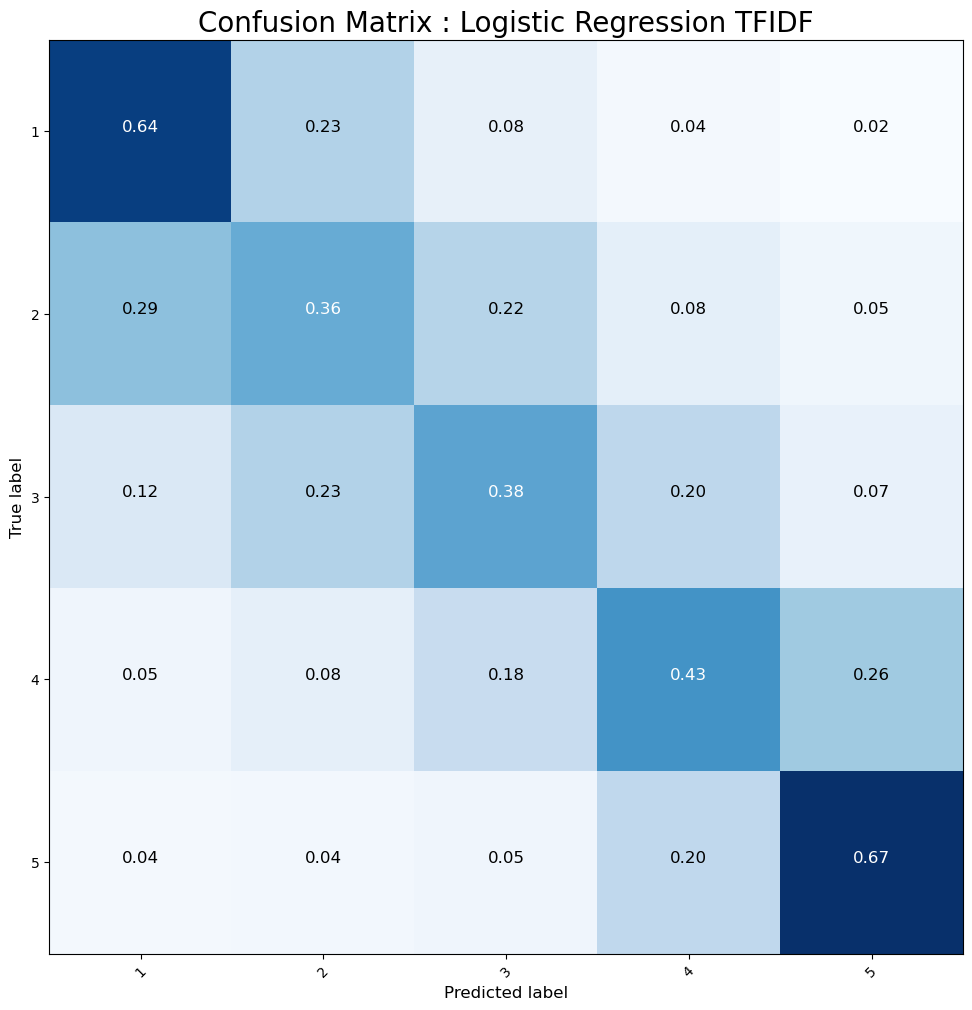

In [75]:
# confusion matrix for logistic regression w/ TF-IDF

plot_confusion_matrix(confusion_matrix(y_test, log_tfidf_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Logistic Regression TFIDF')

In [65]:
# Linear SVC model w TF-IDF

tfidf_vec= TfidfVectorizer(max_features=MAX_FEAT)
clf = LinearSVC(class_weight='balanced', max_iter=MAX_FEAT)
svc_tfidf_pipe = Pipeline([('vectorizer', tfidf_vec), ('Linear SVC', clf)])
svc_tfidf_pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=5000)),
                ('Linear SVC',
                 LinearSVC(class_weight='balanced', max_iter=5000))])

In [66]:
# create preds from pipeline model
svc_tfidf_train_pred = svc_tfidf_pipe.predict(X_train["lemma_sent"])
svc_tfidf_test_pred = svc_tfidf_pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, svc_tfidf_train_pred))
print(classification_report(y_test, svc_tfidf_test_pred))

              precision    recall  f1-score   support

           1       0.58      0.75      0.65     27595
           2       0.29      0.38      0.33     14112
           3       0.39      0.41      0.40     20714
           4       0.44      0.29      0.35     36765
           5       0.85      0.85      0.85    160476

    accuracy                           0.70    259662
   macro avg       0.51      0.53      0.52    259662
weighted avg       0.70      0.70      0.69    259662

              precision    recall  f1-score   support

           1       0.53      0.70      0.61     11630
           2       0.21      0.27      0.24      6173
           3       0.32      0.34      0.33      8826
           4       0.38      0.25      0.30     15870
           5       0.84      0.84      0.84     68785

    accuracy                           0.67    111284
   macro avg       0.46      0.48      0.46    111284
weighted avg       0.67      0.67      0.67    111284



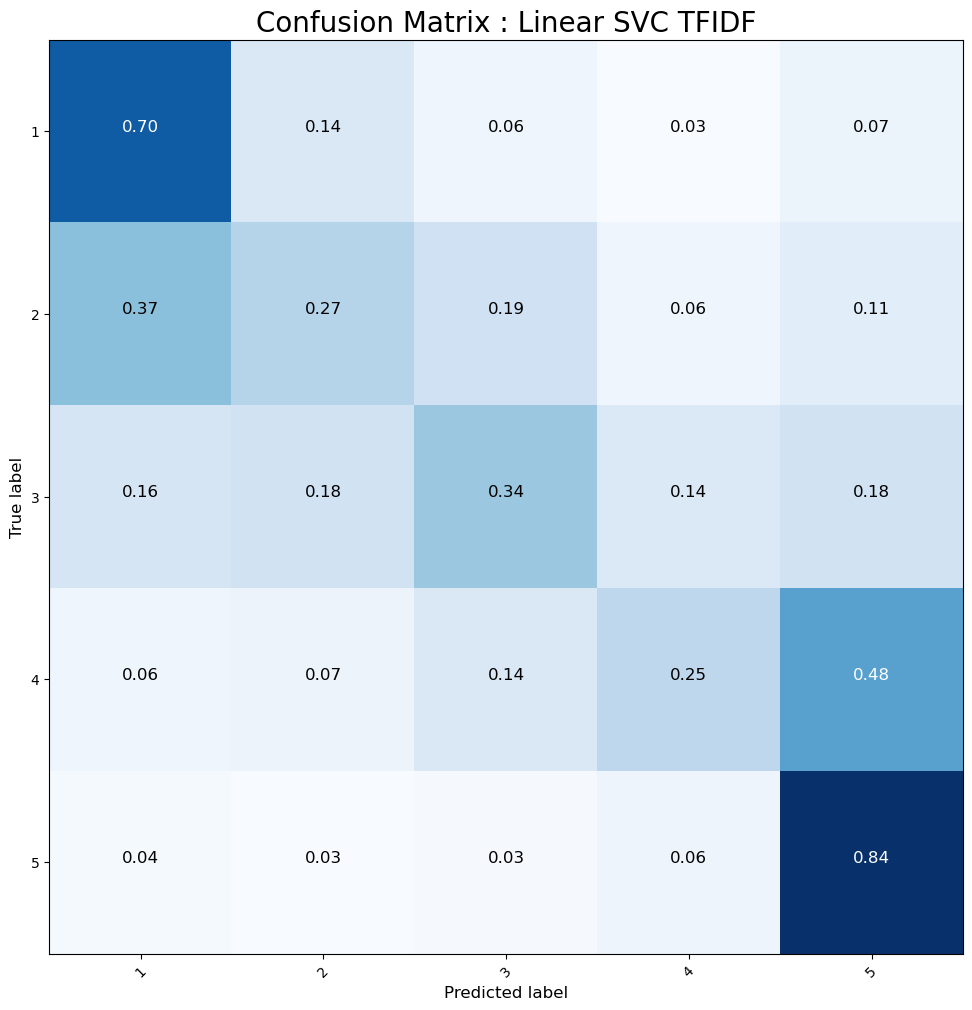

In [77]:
# confusion matrix for linear SVC w/ TF-IDF

plot_confusion_matrix(confusion_matrix(y_test, svc_tfidf_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Linear SVC TFIDF')

In [67]:
# Random Forest model w TF-IDF

tfidf_vec= TfidfVectorizer(max_features=MAX_FEAT)
clf = RandomForestClassifier(random_state=42)
rf_tfidf_pipe = Pipeline([('vectorizer', tfidf_vec), ('Random Forest', clf)])
rf_tfidf_pipe.fit(X_train["lemma_sent"], y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=5000)),
                ('Random Forest', RandomForestClassifier(random_state=42))])

In [68]:
# create preds from pipeline model
rf_tfidf_train_pred = rf_tfidf_pipe.predict(X_train["lemma_sent"])
rf_tfidf_test_pred = rf_tfidf_pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, rf_tfidf_train_pred))
print(classification_report(y_test, rf_tfidf_test_pred))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97     27595
           2       0.98      0.94      0.96     14112
           3       0.97      0.95      0.96     20714
           4       0.99      0.90      0.95     36765
           5       0.97      1.00      0.98    160476

    accuracy                           0.97    259662
   macro avg       0.98      0.95      0.96    259662
weighted avg       0.97      0.97      0.97    259662

              precision    recall  f1-score   support

           1       0.63      0.63      0.63     11630
           2       0.52      0.08      0.14      6173
           3       0.54      0.23      0.33      8826
           4       0.62      0.14      0.23     15870
           5       0.73      0.98      0.84     68785

    accuracy                           0.71    111284
   macro avg       0.61      0.41      0.43    111284
weighted avg       0.68      0.71      0.65    111284



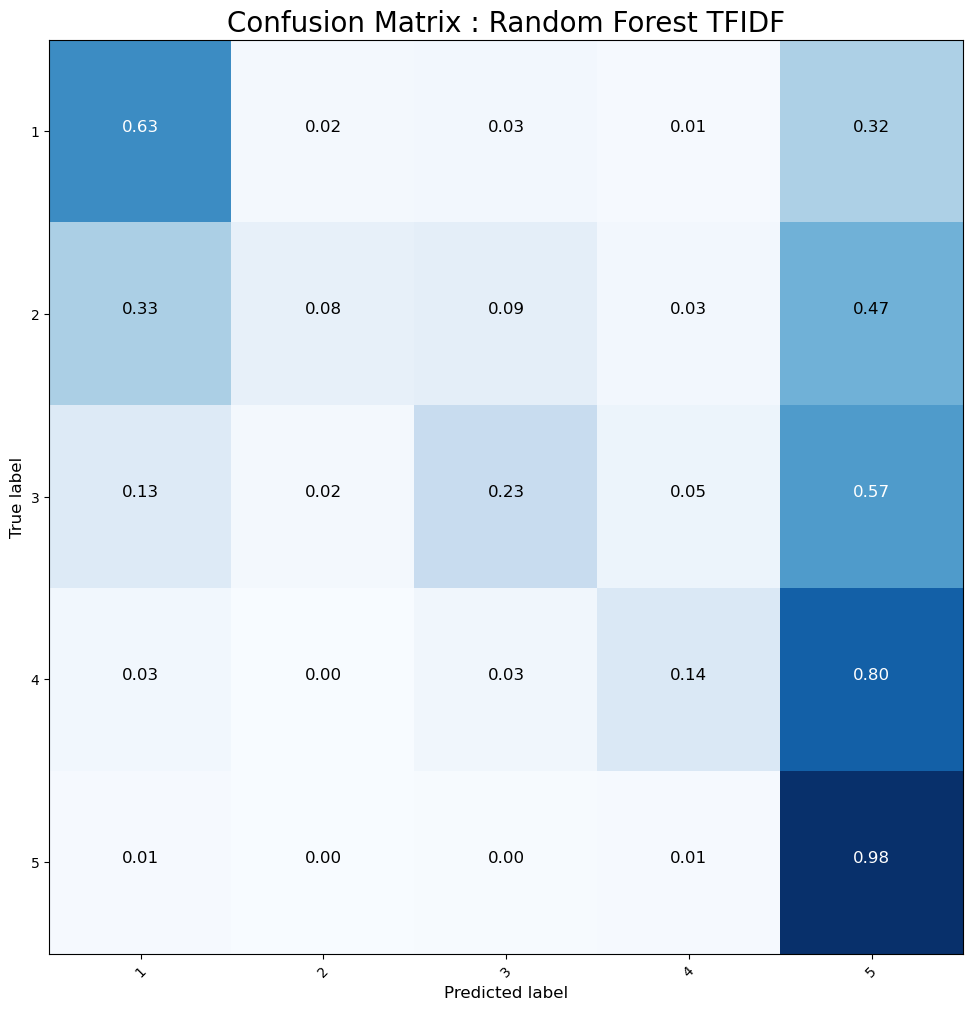

In [73]:
# confusion matrix for Random Forest w/ TF-IDF

plot_confusion_matrix(confusion_matrix(y_test, rf_tfidf_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : Random Forest TFIDF')

In [69]:
# XGBoost model w TF-IDF

tfidf_vec= TfidfVectorizer(max_features=MAX_FEAT)
clf = XGBClassifier(random_state=42, seed=42)
xgb_tfidf_pipe = Pipeline([('vectorizer', tfidf_vec), ('XGBoost', clf)])
xgb_tfidf_pipe.fit(X_train["lemma_sent"], y_train)

c:\Users\bosea\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:29:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=5000)),
                ('XGBoost',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, seed=42, subsample=1,
                               tree_me

In [70]:
# create preds from pipeline model
xgb_tfidf_train_pred = xgb_tfidf_pipe.predict(X_train["lemma_sent"])
xgb_tfidf_test_pred = xgb_tfidf_pipe.predict(X_test["lemma_sent"])
# print classification report
print(classification_report(y_train, xgb_tfidf_train_pred))
print(classification_report(y_test, xgb_tfidf_test_pred))

              precision    recall  f1-score   support

           1       0.72      0.57      0.64     27595
           2       0.77      0.12      0.20     14112
           3       0.62      0.26      0.37     20714
           4       0.64      0.20      0.30     36765
           5       0.73      0.98      0.84    160476

    accuracy                           0.72    259662
   macro avg       0.70      0.43      0.47    259662
weighted avg       0.71      0.72      0.67    259662

              precision    recall  f1-score   support

           1       0.66      0.55      0.60     11630
           2       0.33      0.04      0.07      6173
           3       0.48      0.19      0.27      8826
           4       0.49      0.15      0.23     15870
           5       0.72      0.97      0.83     68785

    accuracy                           0.70    111284
   macro avg       0.54      0.38      0.40    111284
weighted avg       0.64      0.70      0.63    111284



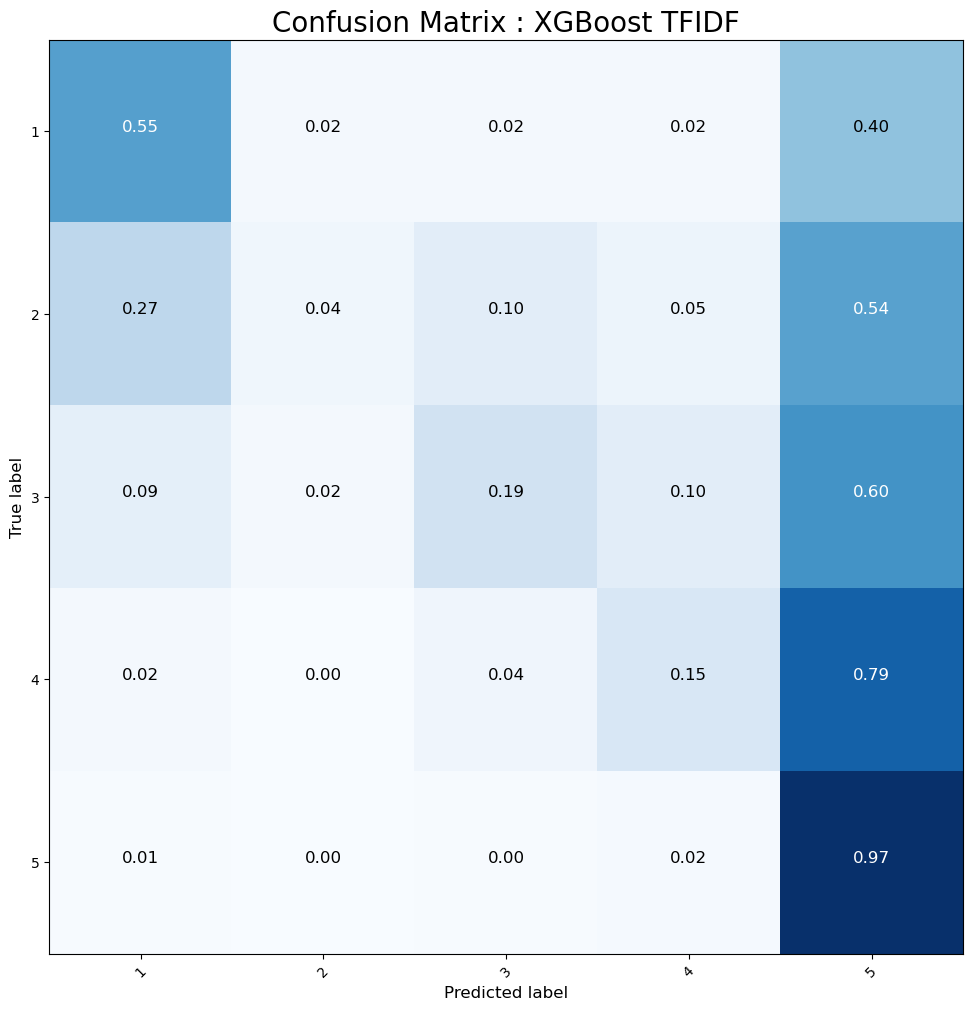

In [72]:
# confusion matrix for XGBoost w/ TF-IDF

plot_confusion_matrix(confusion_matrix(y_test, xgb_tfidf_test_pred), classes=['1', '2', '3', '4', '5'], normalize=True, title=f'Confusion Matrix : XGBoost TFIDF')